# Artificial Intelligence Spring 99 <img src = 'https://ece.ut.ac.ir/cict-theme/images/footer-logo.png' alt="Tehran-University-Logo" width="150" height="150" align="right">
## Project 5 : Image Classification of a Fashion Dataset with Neural Networks
### Dr. Hakimeh Fadaei
### By Omid Vaheb

## Introduction:
At first, I inspected the dataset by checking its distribuion between classes. The next step was to design a neural network's layers and number of neurons in each layer. The rest of project was testing some of the hyperparameters like number of epochs, batch size, learning rate and momentum and some evaluation functions to find the optimal network for this data. 
## Question:
In order to predict categories of clothes from their pictures, we need to build neural network ant tune its parameters to get the highest accuracy. So we have to try various values for this parameters to find the best combination.

The first step, as always, is to import required libraries. I also mounted my google drive because reading from google drive is much faster than reading from my hard drive. Also colab needs to upload the whole dataset each time it runs.

In [2]:
import torchvision
import torch
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import ImageFolder
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import numpy as np
from google.colab import drive
import torch.nn as nn
import torch.nn.functional as F
import time
from datetime import timedelta
from datetime import datetime
import pandas as pd
import tensorflow as tf
from random import randrange
from collections import Counter
from random import shuffle
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


The next step is to load the images using ImageFolder command. Meanwhile we compose 2 transforms on each image: Grayscaling and converting to numpy array(Although the result of neural network changes even with the same input but it doesn't make much difference)

In [3]:
class CustomToTensor(object):
    ## the input image must be grayscaled first
    def __call__(self, image):
        image = np.array(image, dtype = np.float32)
        # numpy image: H x W
        return torch.from_numpy(image)
transform = transforms.Compose([transforms.Grayscale(), CustomToTensor()]) ## composes multiple transforms into single one
dataset = ImageFolder(root = "/content/drive/My Drive/categorized_products", transform = transform)

Now it is time to split dataset to train and test. I also use a constant seed for shuffling so that each run of notebook won't result in a different way.

In [4]:
batch_size = 64
validation_split = 0.2
random_seed = 7

# Creating data indices for training and validation splits:
indices = list(range(len(dataset))) # indices of the dataset
n = len(dataset)  # total number of examples
split = int(np.floor(validation_split * n))
np.random.seed(random_seed)
np.random.shuffle(indices)
train_indices, test_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, sampler = train_sampler, num_workers = 16)
test_loader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, sampler = test_sampler, num_workers = 16)

## Part 1:
Now we view sample picture from 1 random categories.

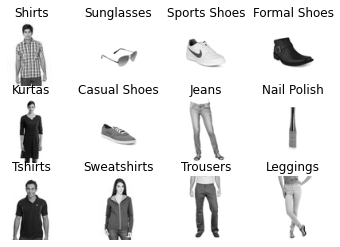

In [5]:
def imshow(img_array, labels, classes):
    _, axs = plt.subplots(3, 4) 
    for i in range(3):
      for j in range(4):
        axs[i][j].imshow(img_array[i * 4 + j], cmap = 'gray')
        axs[i][j].set_title(classes[labels[i * 4 + j]])
        axs[i][j].axis('off')
    plt.show()
classes = dataset.classes
images = list()
categories = list()
while len(images) < 12:
  randomNum = randrange(len(dataset))
  if dataset[randomNum][1] in categories:
    continue
  images.append(dataset[randomNum][0])
  categories.append(dataset[randomNum][1])
imshow(images, categories, classes)

## Part 2:
Then we count number of pictures in each category(I counted the train data not thw whole dtaset but since wh splited 90% of each category, the result is the same) and show them in a bar plot in descending order:

In [5]:
def getCategoryDistribution(loader, classes):
    categoryCount = {classes[i] : 0 for i in range(len(classes))}
    i = 0
    total = len(loader)
    for _, labels in loader:
        i += 1
        for label in labels:
            categoryCount[ classes[label] ] += 1
    return categoryCount
trainDataset = ImageFolder(root = "/content/drive/My Drive/categorized_products", transform = torchvision.transforms.ToTensor())
trainLoader = torch.utils.data.DataLoader(trainDataset, batch_size = 64, num_workers = 16, shuffle = True)
classes = trainDataset.classes
dataset2 = [trainLoader, classes]
datasetLoader = dataset2[0]
datasetClasses = dataset2[1]
categoryCount = getCategoryDistribution(datasetLoader, datasetClasses)
sortedCategories = {k: v for k, v in sorted(categoryCount.items(), key = lambda item: item[1], reverse = True)}
keys = sortedCategories.keys()

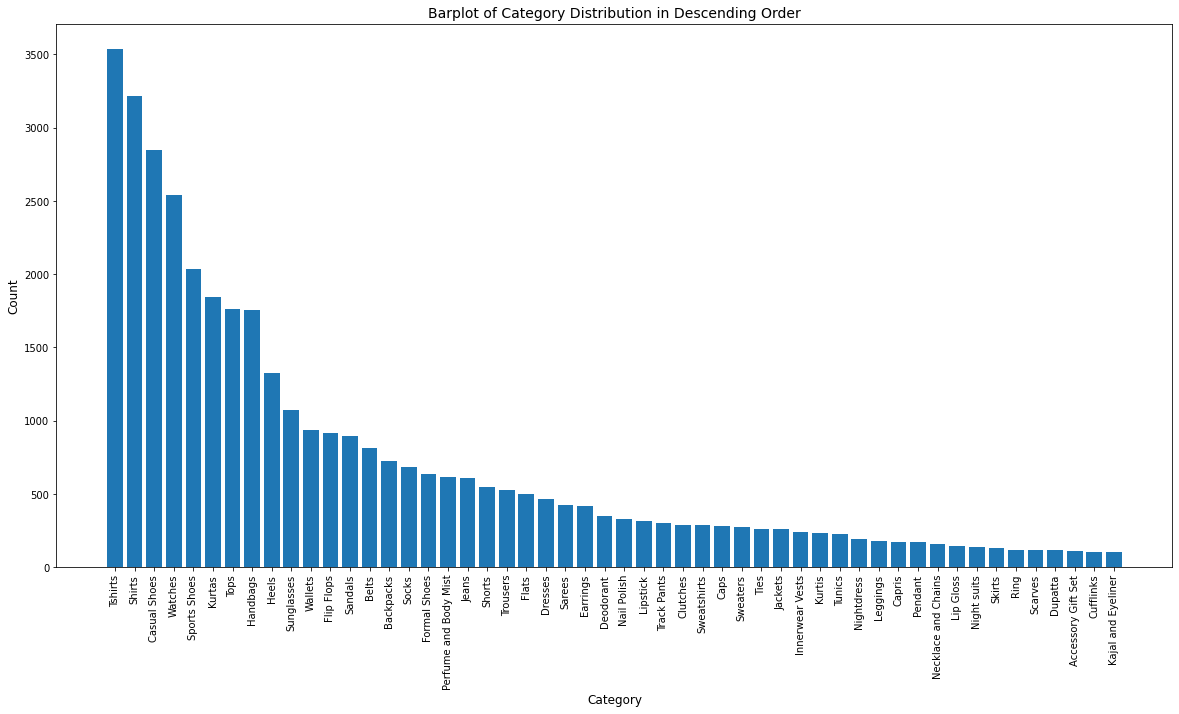

In [6]:
values = sortedCategories.values()
plt.figure(figsize = (20, 10))
plt.xticks(rotation = 90)
plt.bar(keys, values)
plt.xlabel("Category", size = 12)
plt.ylabel("Count", size = 12)
plt.title("Barplot of Category Distribution in Descending Order", size = 14)
plt.show()

## Part 3:
In this step we design the model with 5 layers and decent neurons in each layer. The batch size is 64, and learning rate of 0.01 is chosen. Activation function is relu function and we train model 10 times (epoch is 10). Class model is implemented to define each layer and number of neurons it has. Number of output and number of inputs are known for the model. Because each image is 80*60 pixel and grayscale number of input features are 80*60*1. Number of outputs are equal to number of categories or classes available in dataset. Also this class has forward method which is to implement reshaping of x to a tensor with x.size columns and appropriate rows per columns (denoted with -1) and then to forward values via x.

In [6]:
dataset[0][0].shape

torch.Size([80, 60])

In [7]:
criterion = nn.CrossEntropyLoss()
batch_size = 64
number_of_epochs = 10
learning_rate = 0.01
activation_function = F.relu
class Model(nn.Module):
    def __init__(self, class_num, act = activation_function):
        super(Model, self).__init__()

        self.layer1 = nn.Linear(1 * 80 * 60, 90 * 20 * 15)
        self.act1 = act

        self.layer2 = nn.Linear(90 * 20 * 15, 90 * 10 * 5)
        self.act2 = act

        self.layer3 = nn.Linear(90 * 10 * 5, 45 * 5 * 5)
        self.act3 = act

        self.layer4 = nn.Linear(45 * 5 * 5, 125)
        self.act4 = act

        self.layer5 = nn.Linear(125, class_num)

    def forward(self, x):

        x = x.view(x.size(0), -1)

        x = self.layer1(x)
        x = self.act1(x)

        x = self.layer2(x)
        x = self.act2(x)

        x = self.layer3(x)
        x = self.act3(x)

        x = self.layer4(x)
        x = self.act4(x)

        x = self.layer5(x)
        return x

Now we move the model to GPU.

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [9]:
model = Model(len(classes))
model = model.to(device)

Another important function that we have to implement before training the data, is fit function. In each epoch and inside that per every batch we read from loader then we clear gradiants to train parameters and back propagate and then we store outputs and evaluate loss based on the outputs. Based on this loss model back propagates to minimize it.

In [10]:
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
def fit(model, train_loader, device, criterion, optimizer, num_epochs):

  total_time = 0.
  losses = []
  for epoch in range(num_epochs):
      train_loss = 0.
      d1 = datetime.now()
      for images, labels in train_loader:
          
        images = images.to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images)

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()
        train_loss += loss.item()

      average_loss = train_loss / len(train_loader)
      d2 = datetime.now()
      delta = d2 - d1
      seconds = float(delta.total_seconds())
      total_time += seconds
      print('epoch %d, train_loss: %.3f, time elapsed: %s seconds' % (epoch + 1, average_loss, seconds))
      losses.append(average_loss)
  print('total training time: %.3f minutes' % (total_time / 60))
  return losses

In this part we count number of neurons in each layer and calculate total amount of parameters of the model which is around 250 milion. The method for calculation is finding number of weights between each layer by multiplying number of neurons in each layer.

In [11]:
params = list(model.parameters())
num_parameters = [len(x) for x in params]
for i in range(int(len(num_parameters) / 2)):
  print("Number of Neurons in layer", i + 1, ":", num_parameters[2 * i])
print(model)
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of trainable parameters :", count_parameters(model))

Number of Neurons in layer 1 : 27000
Number of Neurons in layer 2 : 4500
Number of Neurons in layer 3 : 1125
Number of Neurons in layer 4 : 125
Number of Neurons in layer 5 : 52
Model(
  (layer1): Linear(in_features=4800, out_features=27000, bias=True)
  (layer2): Linear(in_features=27000, out_features=4500, bias=True)
  (layer3): Linear(in_features=4500, out_features=1125, bias=True)
  (layer4): Linear(in_features=1125, out_features=125, bias=True)
  (layer5): Linear(in_features=125, out_features=52, bias=True)
)
Number of trainable parameters : 256342427


The preparation part is over and we can start training but unfortunately the first training result is as awfull as it could be without training. The loss is big so it is shown by nan(not a number).

In [40]:
losses = fit(model, train_loader, device, criterion, optimizer, number_of_epochs)

epoch 1, train_loss: nan, time elapsed: 44.111228 seconds
epoch 2, train_loss: nan, time elapsed: 44.153427 seconds
epoch 3, train_loss: nan, time elapsed: 44.099381 seconds
epoch 4, train_loss: nan, time elapsed: 44.135894 seconds
epoch 5, train_loss: nan, time elapsed: 43.973776 seconds
epoch 6, train_loss: nan, time elapsed: 44.173736 seconds
epoch 7, train_loss: nan, time elapsed: 44.153548 seconds
epoch 8, train_loss: nan, time elapsed: 44.098003 seconds
epoch 9, train_loss: nan, time elapsed: 44.06214 seconds
epoch 10, train_loss: nan, time elapsed: 43.98695 seconds
total training time: 7.349 minutes


I have also defined an accuracy calculator which predicts category of each image and checks it with the correct answer and return number of correct guesses divided by all. It works on both train and test data. For this model acuracy is about 0.3% which is so bad that we can understand that our model has not been trained correctly.

In [12]:
def model_accuracy(model, loader):
  correct = 0.
  total = 0.
  with torch.no_grad():
    for images, labels in loader:
      outputs = model(images.to(device))
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted.to('cpu') == labels).sum().item()
  accuracy = 100 * correct / total
  return(accuracy)

In [42]:
print("Train Accuracy :", model_accuracy(model, train_loader), "%")
print("Test Accuracy :", model_accuracy(model, test_loader), "%")

Train Accuracy : 0.30201342281879195 %
Test Accuracy : 0.2819170358437374 %


I also defined a function to draw loss per epoch but it doesn't work here because loss values are nan.

In [13]:
def averageLossesPlot(losses):
  plt.plot(losses)
  plt.xticks(np.arange(10))
  plt.xlabel('Epoch Number')
  plt.ylabel('Average Loss')
  plt.title('Average Loss per Epoch')
  plt.show()

The last metric for our accuracy is recall per each class that we calculate with classesAccuracy function. It also draws bar plot of these recalls for both train and test data.

In [14]:
def classesAccuracy(model, test_loader, train_loader):
  test_correct = np.zeros(len(dataset.classes), dtype = int)
  test_total = np.zeros(len(dataset.classes), dtype = int)
  with torch.no_grad():
    for images, labels in test_loader:
      outputs = model(images.to(device))
      _, predicted = torch.max(outputs.data, 1)
      predicted_array = predicted.to('cpu').tolist()
      labels_array = labels.tolist()
      for i in range(labels.size(0)):
        if labels_array[i] == predicted_array[i]:
          test_correct[labels_array[i]] += 1
        test_total[labels_array[i]] += 1

  train_correct = np.zeros(len(dataset.classes), dtype=int)
  train_total = np.zeros(len(dataset.classes), dtype=int)
  with torch.no_grad():
    for images, labels in train_loader:
      outputs = model(images.to(device))
      _, predicted = torch.max(outputs.data, 1)
      predicted_array = predicted.to('cpu').tolist()
      labels_array = labels.tolist()
      for i in range(labels.size(0)):
        if labels_array[i] == predicted_array[i]:
          train_correct[labels_array[i]] += 1
        train_total[labels_array[i]] += 1

  test_accuracy = list()
  train_accuracy = list()
  for i in range(len(dataset.classes)):
    if test_total[i] == 0:
      test_accuracy.append(0)
    else:
      test_accuracy.append(test_correct[i] / test_total[i] * 100)

    if train_total[i] == 0:
      train_accuracy.append(0)
    else:
      train_accuracy.append(train_correct[i] / train_total[i] * 100)
  n_groups = len(dataset.classes)
  fig, ax = plt.subplots()
  index = np.arange(n_groups)
  bar_width = 0.5
  opacity = 0.7
  rects1 = plt.bar(index, test_accuracy, bar_width, alpha = opacity, color = 'b', label = 'Test')
  rects2 = plt.bar(index + bar_width, train_accuracy, bar_width, alpha = opacity, color = 'r', label = 'Train')
  plt.xlabel('Class')
  plt.ylabel('Accuracy')
  plt.title('Model Accuracy')
  plt.xticks(index + bar_width, range(len(dataset.classes)))
  plt.legend()

  plt.tight_layout()
  fig.set_size_inches(20, 10, forward = True)
  plt.show()

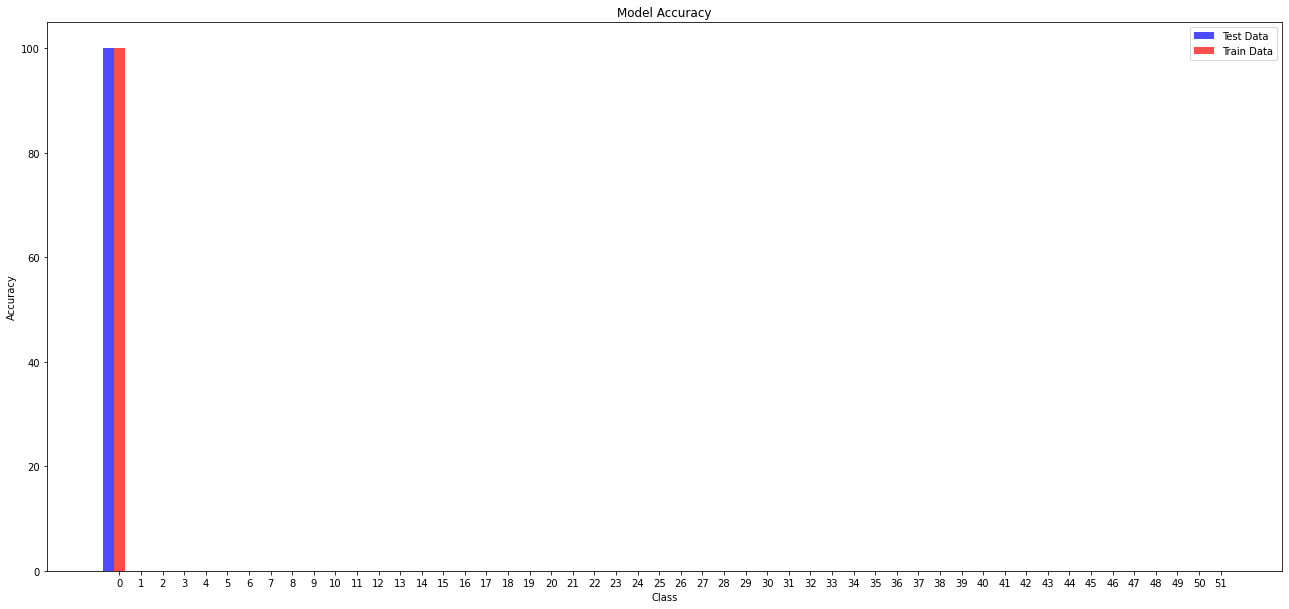

In [48]:
classesAccuracy(model, test_loader, train_loader)

We could see that recall of class 0 is 100% and other classes are 0%. It is clear that our model predicts class of all inputs the same, class 0. Recall is equal to tp/tp+fn and fn for class 0 is 0 and for other classes tp is 0. The problem in this model is that we didn't normalize values of features. Each image consists of 80*60 pixels which are input of model. Each pixel have a value between 0-255 and we know that our network calculates new weights by summation of current weight and multiply of gradiant error and learning rate. If a pixel is more colorful than others and has a high value the correction on it will overcompenate nad others will underconsempate. 
## Part 4:
So we add another transform which divides value of each pixel by 255.

In [15]:
class CustomToTensor2(object):
    ## the input image must be grayscaled first
    def __call__(self, image):
        image = np.array(image, dtype = np.float32) / 255
        # numpy image: H x W
        return torch.from_numpy(image)
transform2 = transforms.Compose([transforms.Grayscale(), CustomToTensor2()]) ## composes multiple transforms into single one
dataset2 = ImageFolder(root = "/content/drive/My Drive/categorized_products", transform = transform2)
batch_size = 64
validation_split = 0.2
random_seed = 7
learning_rate = 0.01

train_sampler2 = SubsetRandomSampler(train_indices)
test_sampler2 = SubsetRandomSampler(test_indices)

train_loader2 = torch.utils.data.DataLoader(dataset2, batch_size = batch_size, sampler = train_sampler2, num_workers = 16)
test_loader2 = torch.utils.data.DataLoader(dataset2, batch_size = batch_size, sampler = test_sampler2, num_workers = 16)

model2 = Model(len(dataset2.classes))
model2 = model2.to(device)
criterion2 = nn.CrossEntropyLoss()
optimizer2 = torch.optim.SGD(model2.parameters(), lr = learning_rate)

In [ ]:
losses = fit(model2, train_loader2, device, criterion2, optimizer2, number_of_epochs)

In [51]:
print("Train Accuracy :", model_accuracy(model2, train_loader2), "%")
print("Test Accuracy :", model_accuracy(model2, test_loader2), "%")

Train Accuracy : 60.013422818791945 %
Test Accuracy : 59.4442207007652 %


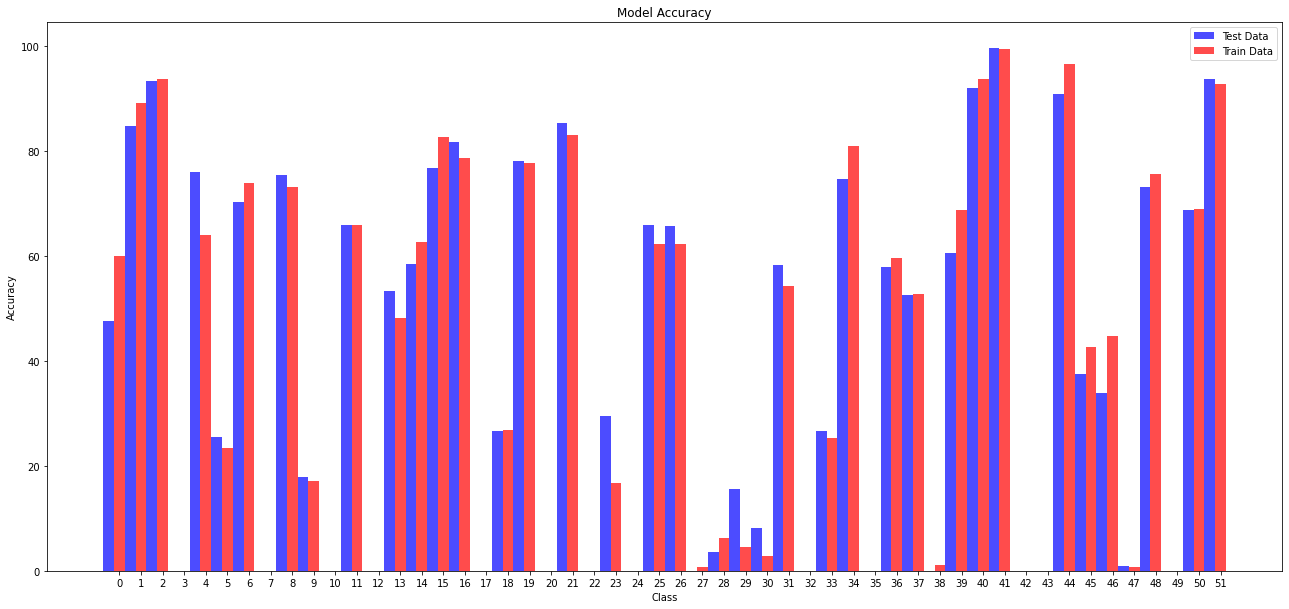

In [56]:
classesAccuracy(model2, test_loader2, train_loader2)

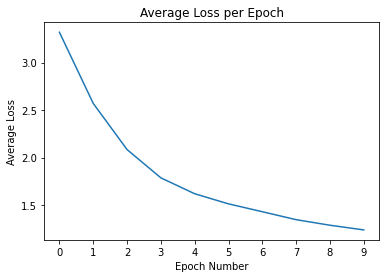

In [57]:
averageLossesPlot(losses)

It is clear that by normalizing data our model has a much better performance and we got 60% accuracy.
## Part 5:
Now we train our model again but this time we initialise weights with zero value. This way out network will become a linear predictor because weights in each layer will stay zero and the only layer that predicts is the last one. Although we got 60% accuracy in last part, We get about 10% acuracy which is the best a linear predictor can go for(it predicts every image same category which is the one with most train inout).

In [15]:
batch_size = 64
number_of_epochs = 10
learning_rate = 0.01
activation_function = F.relu
class Model(nn.Module):
    def __init__(self, class_num, act = activation_function):
        super(Model, self).__init__()

        self.layer1 = nn.Linear(1 * 80 * 60, 90 * 20 * 15)
        self.act1 = act
        self.layer1.weight.data.fill_(0)
        self.layer1.bias.data.fill_(0)

        self.layer2 = nn.Linear(90 * 20 * 15, 90 * 10 * 5)
        self.act2 = act
        self.layer2.weight.data.fill_(0)
        self.layer2.bias.data.fill_(0)

        self.layer3 = nn.Linear(90 * 10 * 5, 45 * 5 * 5)
        self.act3 = act
        self.layer3.weight.data.fill_(0)
        self.layer3.bias.data.fill_(0)

        self.layer4 = nn.Linear(45 * 5 * 5, 125)
        self.act4 = act
        self.layer4.weight.data.fill_(0)
        self.layer4.bias.data.fill_(0)

        self.layer5 = nn.Linear(125, class_num)
        self.layer5.weight.data.fill_(0)
        self.layer5.bias.data.fill_(0)

    def forward(self, x):

        x = x.view(x.size(0), -1)

        x = self.layer1(x)
        x = self.act1(x)

        x = self.layer2(x)
        x = self.act2(x)

        x = self.layer3(x)
        x = self.act3(x)

        x = self.layer4(x)
        x = self.act4(x)

        x = self.layer5(x)
        return x
model = Model(len(dataset2.classes))
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
losses = fit(model, train_loader2, device, criterion, optimizer, number_of_epochs)

epoch 1, train_loss: 3.895, time elapsed: 1203.128685 seconds
epoch 2, train_loss: 3.798, time elapsed: 35.453179 seconds
epoch 3, train_loss: 3.720, time elapsed: 34.710684 seconds
epoch 4, train_loss: 3.660, time elapsed: 34.926039 seconds
epoch 5, train_loss: 3.615, time elapsed: 35.351161 seconds
epoch 6, train_loss: 3.582, time elapsed: 34.540526 seconds
epoch 7, train_loss: 3.556, time elapsed: 34.435043 seconds
epoch 8, train_loss: 3.537, time elapsed: 35.036996 seconds
epoch 9, train_loss: 3.523, time elapsed: 34.830063 seconds
epoch 10, train_loss: 3.512, time elapsed: 34.715484 seconds
total training time: 25.285 minutes


In [17]:
print("Train Accuracy :", model_accuracy(model, train_loader2), "%")
print("Test Accuracy :", model_accuracy(model, test_loader2), "%")

Train Accuracy : 9.483221476510067 %
Test Accuracy : 9.50463149416029 %


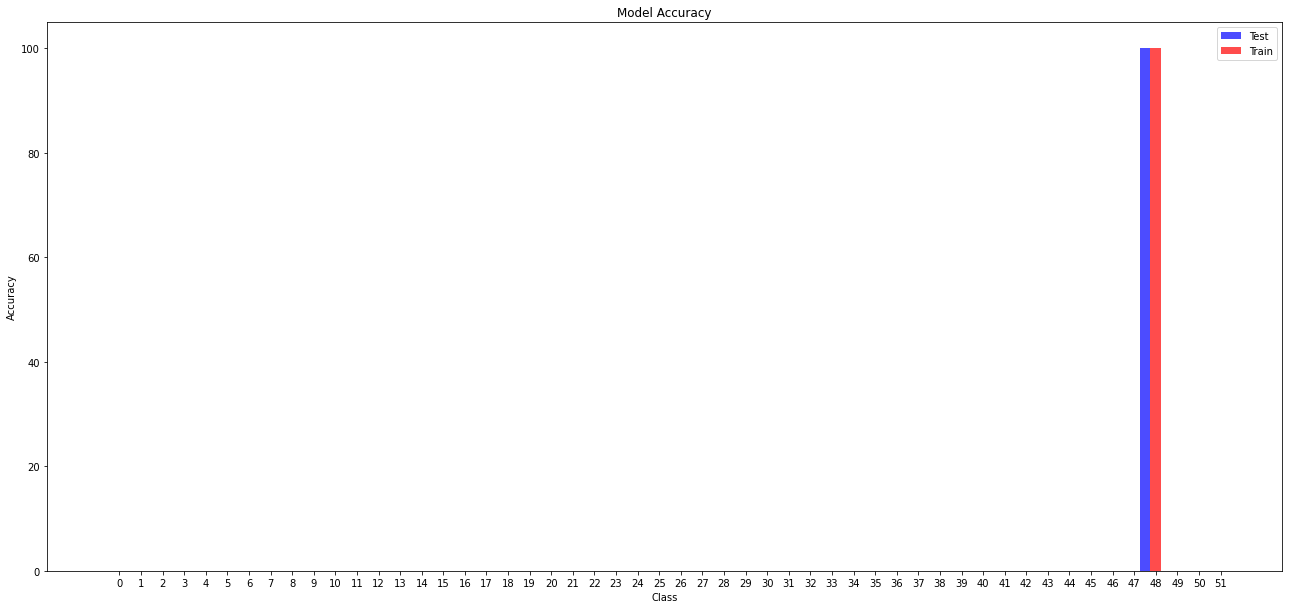

In [18]:
classesAccuracy(model, test_loader2, train_loader2)

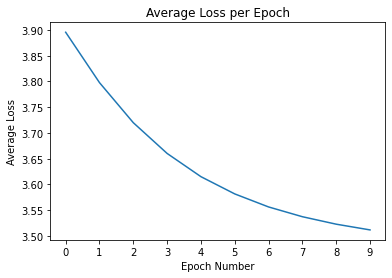

In [19]:
averageLossesPlot(losses)

We saw that random initialization is much better than zero initialization but randomness still has some problems such as:

a) If weights are initialized with very high values the correction term for weights becomes significantly higher and if an activation function like sigmoid is applied, the function maps its value near to 1 where the slope of gradient changes slowly and learning takes a lot of time.

b) If weights are initialized with low values it gets mapped to 0, where the case is the same as above.
There are some techniques for handling this problem:

**He initialization**: we just simply multiply random initialization with
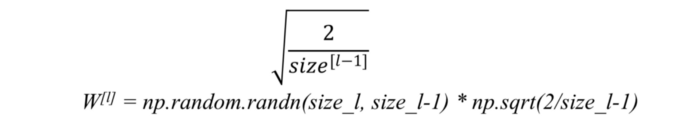

**Xavier initialization**: It is same as He initialization but it is used for tanh activation function, in this method 2 is replaced with 1.
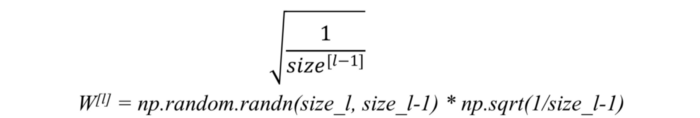

## Part6:
In this part I tried 5 different learning rates and found out that 0.05 is best one for my model with 65% accuracy.

**Learning rate = 0.1** : This learning rate updates weights with bigger steps so during training, it might miss optimum point many times and might never reach the optimum accuracy. We can see that accuracy is 61% with this rate.

**Learnig rate = 0.001** : This learning rate slows back-propogation and weight correction part of network and it might even fail in training data. The accuracy for this learning rate is 24% which shows that we needed many more epochs and more time for training in comparison with 0.05 learning rate.

In conclusion increasing this rate may cause instability and lowers accuracy and decresing it could slow our model as much as it gets untrainable.

In [20]:
learning_rates = [0.001, 0.005, 0.01, 0.05, 0.1]
batch_size = 64
number_of_epochs = 10
class Model(nn.Module):
    def __init__(self, class_num, act = activation_function):
        super(Model, self).__init__()

        self.layer1 = nn.Linear(1 * 80 * 60, 90 * 20 * 15)
        self.act1 = act

        self.layer2 = nn.Linear(90 * 20 * 15, 90 * 10 * 5)
        self.act2 = act

        self.layer3 = nn.Linear(90 * 10 * 5, 45 * 5 * 5)
        self.act3 = act

        self.layer4 = nn.Linear(45 * 5 * 5, 125)
        self.act4 = act

        self.layer5 = nn.Linear(125, class_num)

    def forward(self, x):

        x = x.view(x.size(0), -1)

        x = self.layer1(x)
        x = self.act1(x)

        x = self.layer2(x)
        x = self.act2(x)

        x = self.layer3(x)
        x = self.act3(x)

        x = self.layer4(x)
        x = self.act4(x)

        x = self.layer5(x)
        return x

Learning Rate : 0.001
epoch 1, train_loss: 3.836, time elapsed: 36.092932 seconds
epoch 2, train_loss: 3.529, time elapsed: 35.552727 seconds
epoch 3, train_loss: 3.437, time elapsed: 36.189975 seconds
epoch 4, train_loss: 3.398, time elapsed: 36.194038 seconds
epoch 5, train_loss: 3.345, time elapsed: 35.774845 seconds
epoch 6, train_loss: 3.248, time elapsed: 36.120037 seconds
epoch 7, train_loss: 3.101, time elapsed: 35.911925 seconds
epoch 8, train_loss: 2.960, time elapsed: 35.638084 seconds
epoch 9, train_loss: 2.852, time elapsed: 35.661891 seconds
epoch 10, train_loss: 2.762, time elapsed: 35.392726 seconds
total training time: 5.975 minutes
Train Accuracy : 24.536912751677853 %
Test Accuracy : 23.64075714861055 %


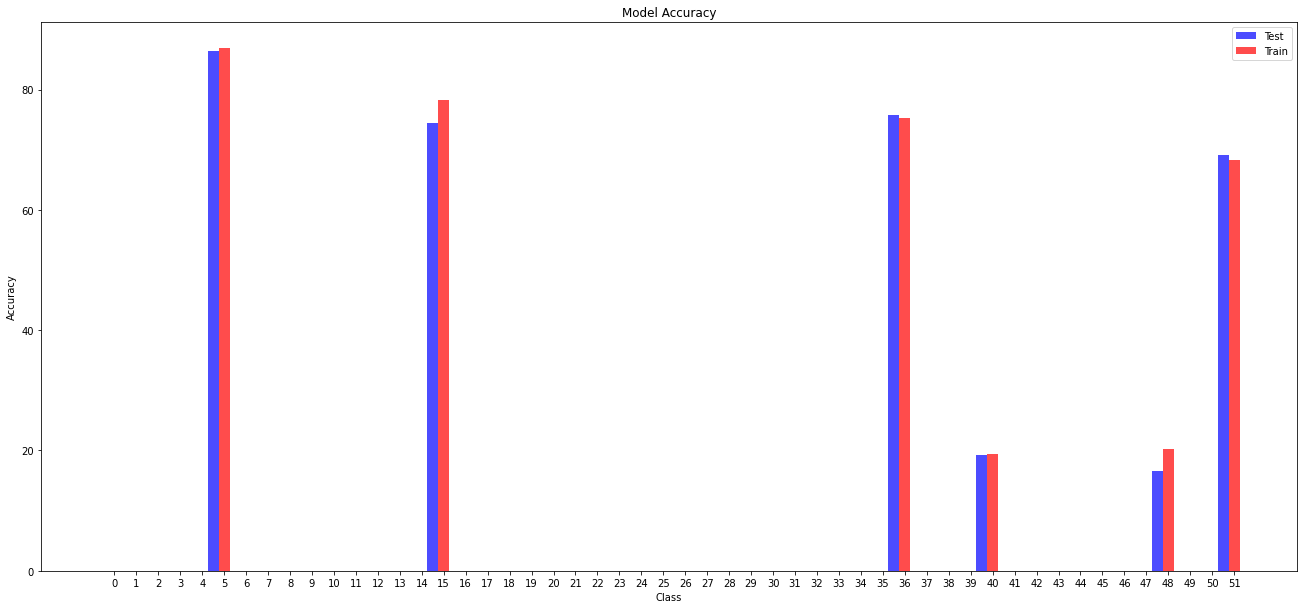

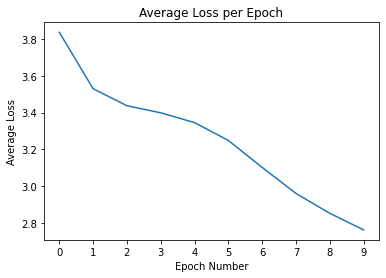

Learning Rate : 0.005
epoch 1, train_loss: 3.535, time elapsed: 37.082081 seconds
epoch 2, train_loss: 3.057, time elapsed: 35.840285 seconds
epoch 3, train_loss: 2.642, time elapsed: 36.841026 seconds
epoch 4, train_loss: 2.341, time elapsed: 36.578747 seconds
epoch 5, train_loss: 2.106, time elapsed: 36.710523 seconds
epoch 6, train_loss: 1.915, time elapsed: 36.085328 seconds
epoch 7, train_loss: 1.767, time elapsed: 36.622184 seconds
epoch 8, train_loss: 1.659, time elapsed: 36.033052 seconds
epoch 9, train_loss: 1.595, time elapsed: 36.548267 seconds
epoch 10, train_loss: 1.537, time elapsed: 36.738414 seconds
total training time: 6.085 minutes
Train Accuracy : 47.23489932885906 %
Test Accuracy : 46.67740636327024 %


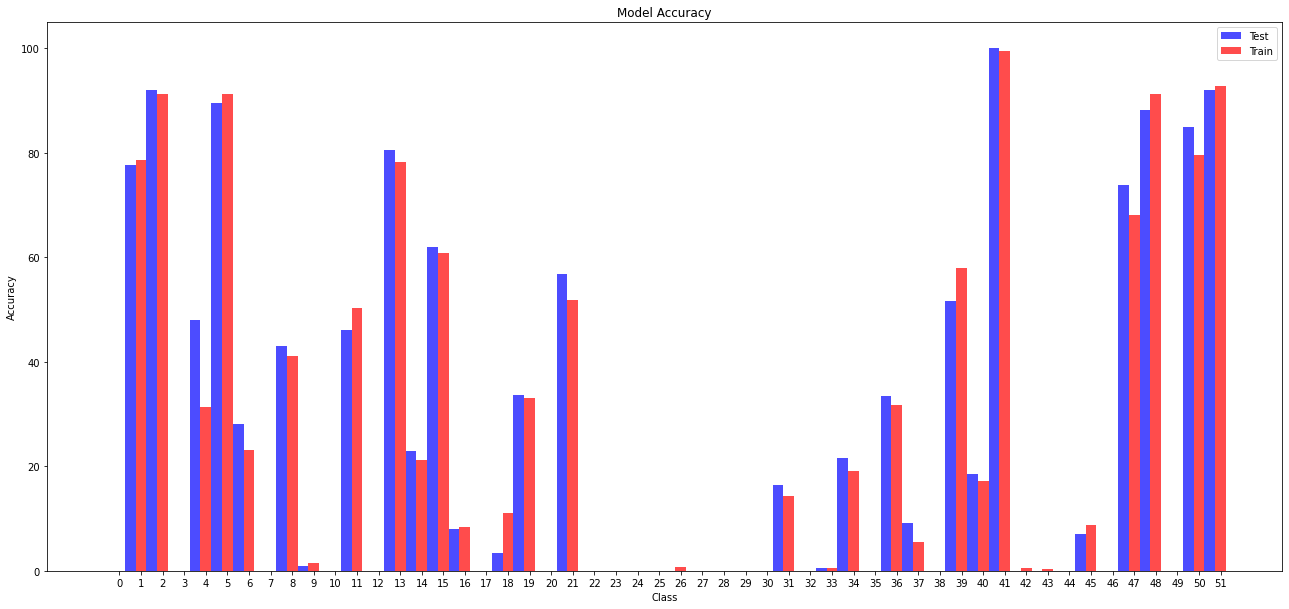

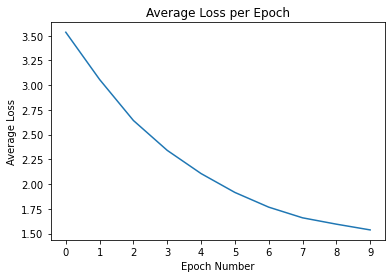

Learning Rate : 0.01
epoch 1, train_loss: 3.324, time elapsed: 36.202043 seconds
epoch 2, train_loss: 2.598, time elapsed: 36.031755 seconds
epoch 3, train_loss: 2.130, time elapsed: 35.590975 seconds
epoch 4, train_loss: 1.833, time elapsed: 36.037137 seconds
epoch 5, train_loss: 1.660, time elapsed: 36.176184 seconds
epoch 6, train_loss: 1.544, time elapsed: 36.136116 seconds
epoch 7, train_loss: 1.443, time elapsed: 36.513347 seconds
epoch 8, train_loss: 1.367, time elapsed: 35.831114 seconds
epoch 9, train_loss: 1.311, time elapsed: 36.724419 seconds
epoch 10, train_loss: 1.251, time elapsed: 35.908555 seconds
total training time: 6.019 minutes
Train Accuracy : 52.446308724832214 %
Test Accuracy : 52.141227010336955 %


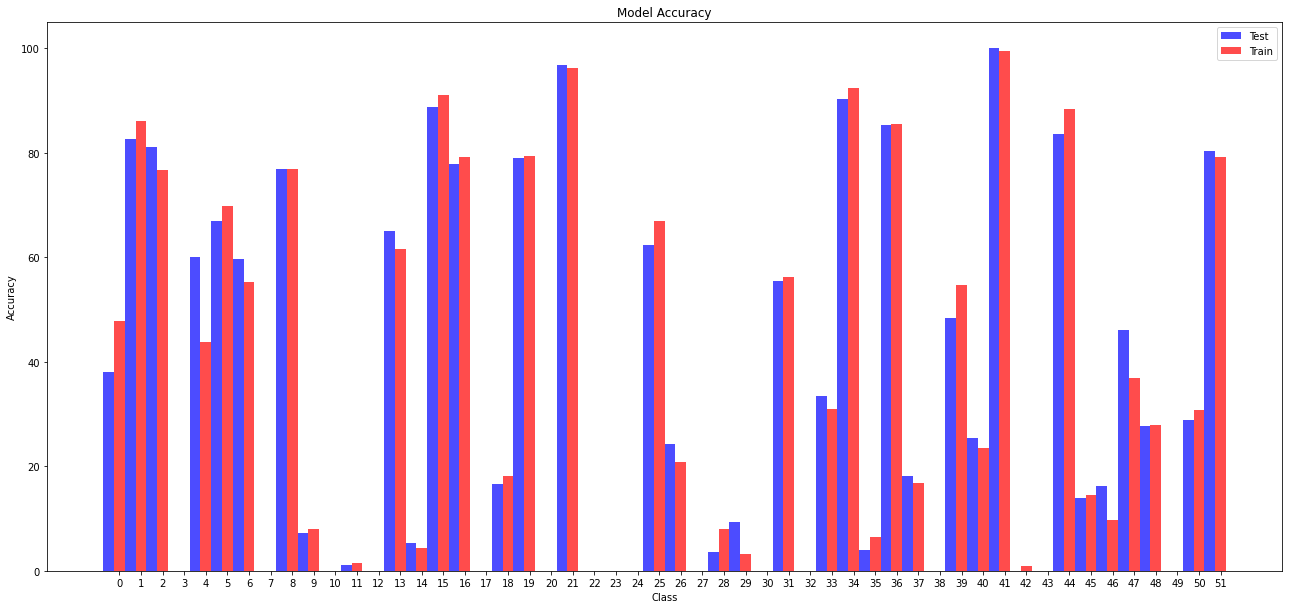

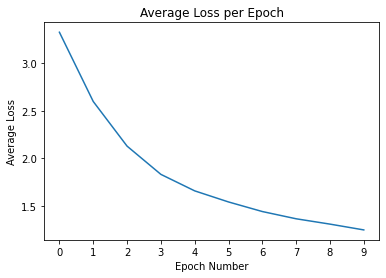

Learning Rate : 0.05
epoch 1, train_loss: 2.719, time elapsed: 35.328765 seconds
epoch 2, train_loss: 1.884, time elapsed: 35.414467 seconds
epoch 3, train_loss: 1.593, time elapsed: 37.02981 seconds
epoch 4, train_loss: 1.405, time elapsed: 36.680751 seconds
epoch 5, train_loss: 1.284, time elapsed: 35.891226 seconds
epoch 6, train_loss: 1.194, time elapsed: 35.648139 seconds
epoch 7, train_loss: 1.127, time elapsed: 35.309966 seconds
epoch 8, train_loss: 1.067, time elapsed: 35.313259 seconds
epoch 9, train_loss: 1.028, time elapsed: 34.981192 seconds
epoch 10, train_loss: 0.975, time elapsed: 35.711296 seconds
total training time: 5.955 minutes
Train Accuracy : 66.58053691275168 %
Test Accuracy : 65.25708148744798 %


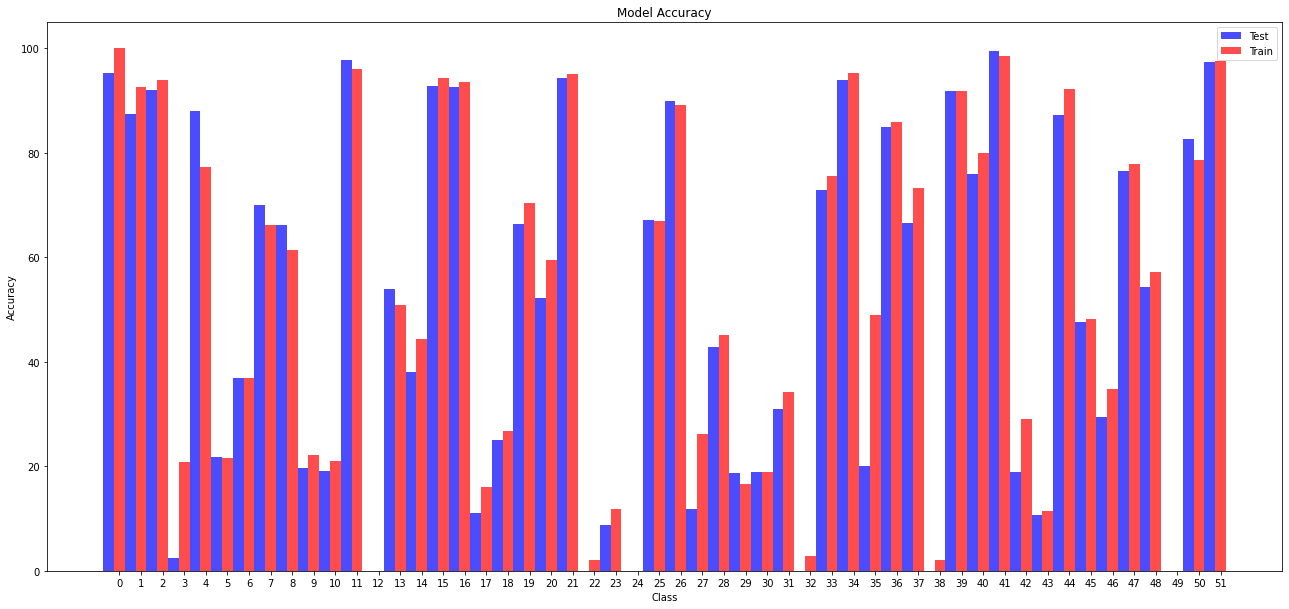

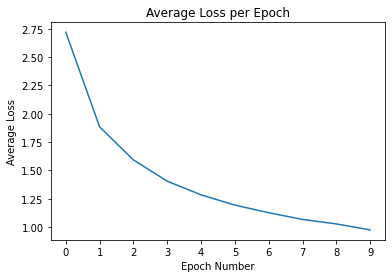

Learning Rate : 0.1
epoch 1, train_loss: 2.825, time elapsed: 35.45085 seconds
epoch 2, train_loss: 2.047, time elapsed: 36.171891 seconds
epoch 3, train_loss: 1.704, time elapsed: 35.688978 seconds
epoch 4, train_loss: 1.481, time elapsed: 35.227691 seconds
epoch 5, train_loss: 1.387, time elapsed: 35.345015 seconds
epoch 6, train_loss: 1.256, time elapsed: 35.474544 seconds
epoch 7, train_loss: 1.158, time elapsed: 35.713218 seconds
epoch 8, train_loss: 1.111, time elapsed: 35.225999 seconds
epoch 9, train_loss: 1.063, time elapsed: 35.630262 seconds
epoch 10, train_loss: 0.995, time elapsed: 35.759265 seconds
total training time: 5.928 minutes
Train Accuracy : 63.91275167785235 %
Test Accuracy : 62.19626795543026 %


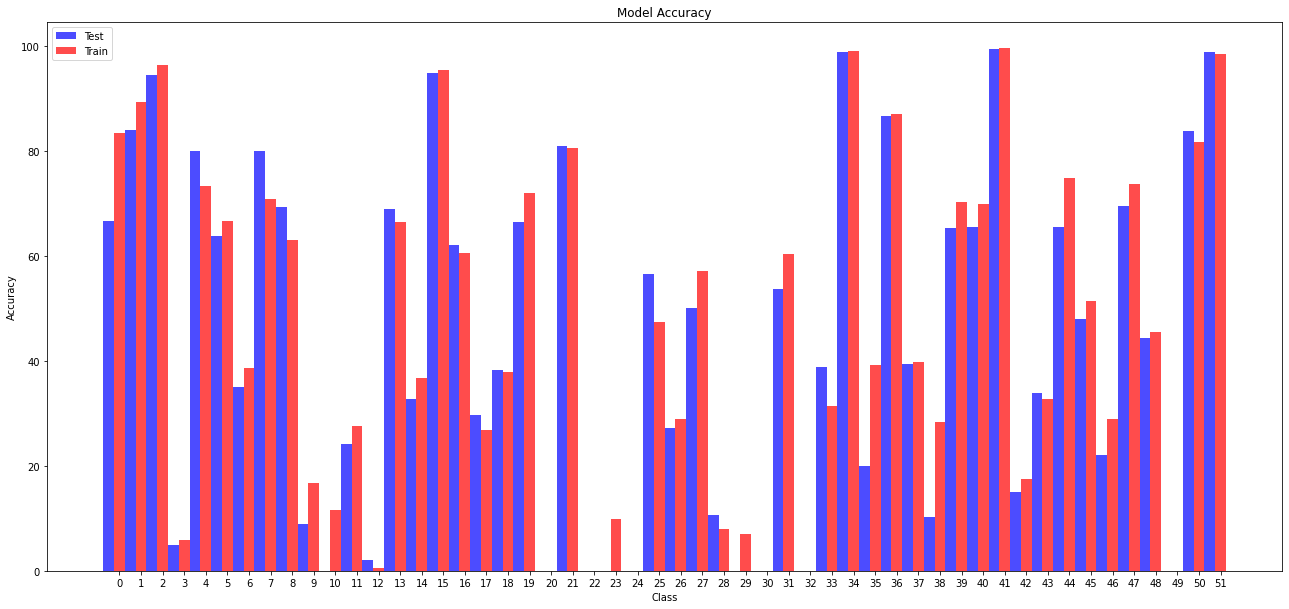

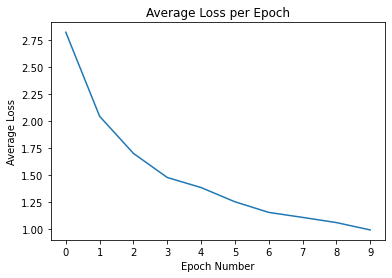

In [22]:
for learning_rate in learning_rates:
  model = Model(len(dataset2.classes))
  model = model.to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
  print("Learning Rate :", learning_rate)
  losses = fit(model, train_loader2, device, criterion, optimizer, number_of_epochs)
  print("Train Accuracy :", model_accuracy(model, train_loader2), "%")
  print("Test Accuracy :", model_accuracy(model, test_loader2), "%")
  classesAccuracy(model, test_loader2, train_loader2)
  averageLossesPlot(losses)

## Part 7:
In the next part we try 32 and 126 for batch size.
### Bigger batch size:

Pros:
1.   Parallelization of training.
2.   It might not get stuck in local optimums.
3.   In each epoch weights might change a lot so learning is faster.

Cons:
1.   Each iteration would need more computation so it will handle more data.
2.   Large batch sizes usually converge to sharp minimizers.

### Smaller batch size:

Pros:
1.   Each batch would change weights a bit so it can stop overfitting
2.   Each iteration consists of leass data so it is more focused

Cons :
1.   It might not lead to global optimum answer.
2.   Parallel training becomes more sequential. 
3.   Small batch size converges to flat minimizers.

Usually batch sizes between 16 to 128 are adequete and in this model 64 is the best one with 65% accuracy and after that is 128 with 64% accuracy(It is clear that the difference is not that much).

Batch Size : 32
epoch 1, train_loss: 2.458, time elapsed: 44.165674 seconds
epoch 2, train_loss: 1.659, time elapsed: 43.962628 seconds
epoch 3, train_loss: 1.405, time elapsed: 43.93784 seconds
epoch 4, train_loss: 1.289, time elapsed: 43.985113 seconds
epoch 5, train_loss: 1.164, time elapsed: 44.067381 seconds
epoch 6, train_loss: 1.089, time elapsed: 43.984375 seconds
epoch 7, train_loss: 1.013, time elapsed: 44.076749 seconds
epoch 8, train_loss: 0.968, time elapsed: 44.02461 seconds
epoch 9, train_loss: 0.927, time elapsed: 43.931685 seconds
epoch 10, train_loss: 0.892, time elapsed: 43.995627 seconds
total training time: 7.336 minutes
Train Accuracy : 65.47651006711409 %
Test Accuracy : 63.12256678748825 %


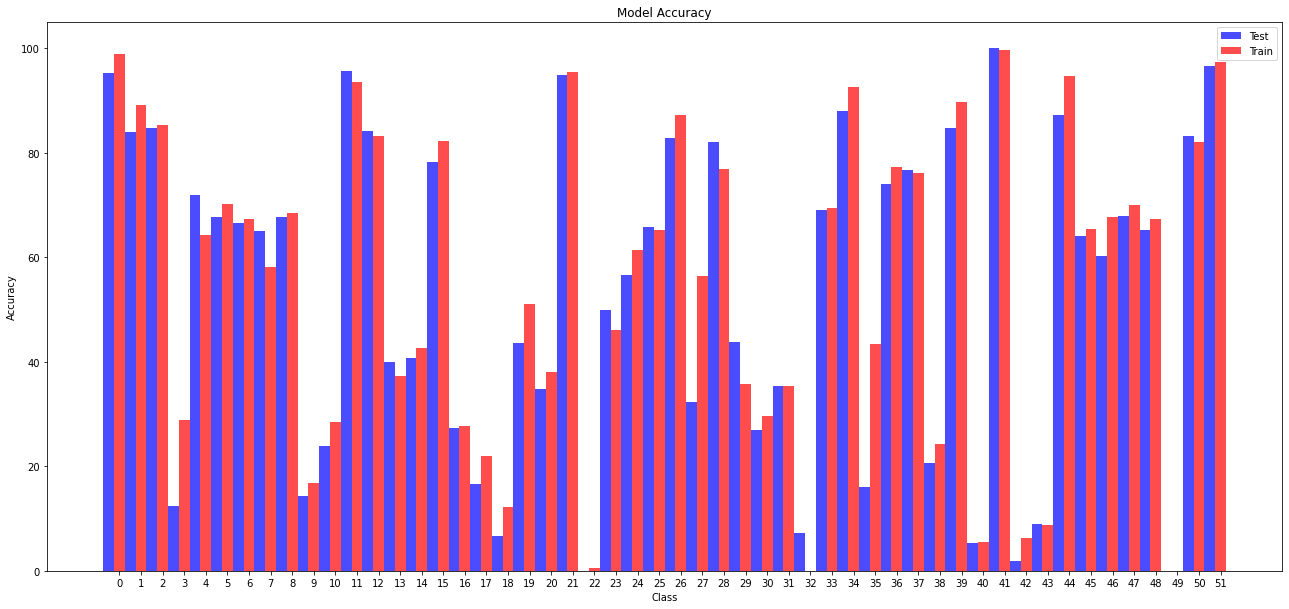

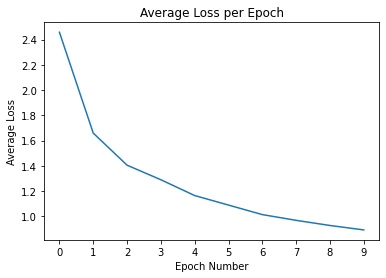

In [20]:
learning_rate = 0.05
batch_size = 32
number_of_epochs = 10
train_loader3 = torch.utils.data.DataLoader(dataset2, batch_size = batch_size, sampler = train_sampler2, num_workers = 16)
test_loader3 = torch.utils.data.DataLoader(dataset2, batch_size = batch_size, sampler = test_sampler2, num_workers = 16)
model = Model(len(dataset2.classes))
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
print("Batch Size :", 32)
losses = fit(model, train_loader3, device, criterion, optimizer, number_of_epochs)
print("Train Accuracy :", model_accuracy(model, train_loader3), "%")
print("Test Accuracy :", model_accuracy(model, test_loader3), "%")
classesAccuracy(model, test_loader3, train_loader3)
averageLossesPlot(losses)

Batch Size : 128
epoch 1, train_loss: 3.043, time elapsed: 33.222767 seconds
epoch 2, train_loss: 2.219, time elapsed: 33.327805 seconds
epoch 3, train_loss: 1.917, time elapsed: 34.452083 seconds
epoch 4, train_loss: 1.662, time elapsed: 34.095819 seconds
epoch 5, train_loss: 1.531, time elapsed: 33.792455 seconds
epoch 6, train_loss: 1.417, time elapsed: 33.785661 seconds
epoch 7, train_loss: 1.318, time elapsed: 33.176808 seconds
epoch 8, train_loss: 1.267, time elapsed: 33.329693 seconds
epoch 9, train_loss: 1.202, time elapsed: 33.754974 seconds
epoch 10, train_loss: 1.136, time elapsed: 33.070492 seconds
total training time: 5.600 minutes
Train Accuracy : 64.97986577181209 %
Test Accuracy : 64.04886561954625 %


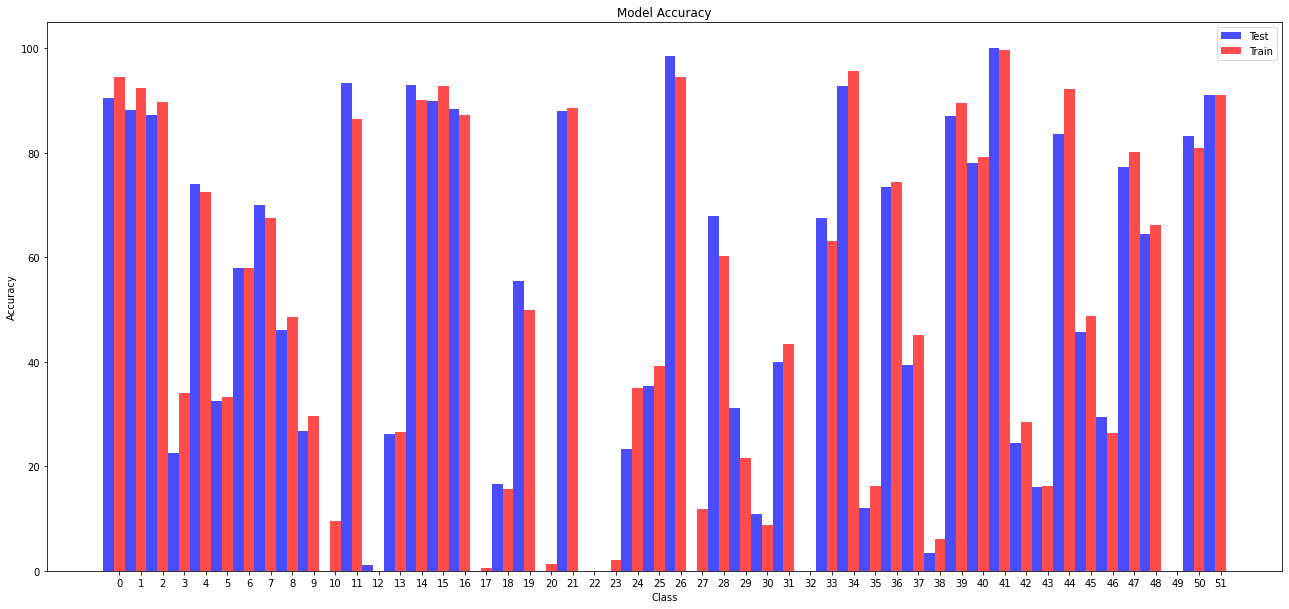

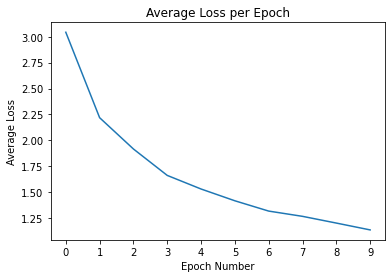

In [21]:
learning_rate = 0.05
batch_size = 128
train_loader4 = torch.utils.data.DataLoader(dataset2, batch_size = batch_size, sampler = train_sampler2, num_workers = 16)
test_loader4 = torch.utils.data.DataLoader(dataset2, batch_size = batch_size, sampler = test_sampler2, num_workers = 16)
model = Model(len(dataset2.classes))
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
print("Batch Size :", 128)
losses = fit(model, train_loader4, device, criterion, optimizer, number_of_epochs)
print("Train Accuracy :", model_accuracy(model, train_loader4), "%")
print("Test Accuracy :", model_accuracy(model, test_loader4), "%")
classesAccuracy(model, test_loader4, train_loader4)
averageLossesPlot(losses)

Batch Size is 128 and learning rate is increased to 0.07
epoch 1, train_loss: 2.995, time elapsed: 1018.710638 seconds
epoch 2, train_loss: 2.230, time elapsed: 34.86141 seconds
epoch 3, train_loss: 1.933, time elapsed: 35.431021 seconds
epoch 4, train_loss: 1.646, time elapsed: 35.31756 seconds
epoch 5, train_loss: 1.487, time elapsed: 34.078583 seconds
epoch 6, train_loss: 1.406, time elapsed: 34.652293 seconds
epoch 7, train_loss: 1.303, time elapsed: 35.224198 seconds
epoch 8, train_loss: 1.262, time elapsed: 35.557049 seconds
epoch 9, train_loss: 1.190, time elapsed: 33.926939 seconds
epoch 10, train_loss: 1.148, time elapsed: 35.838843 seconds
total training time: 22.227 minutes
Train Accuracy : 64.41275167785236 %
Test Accuracy : 63.055443683715936 %


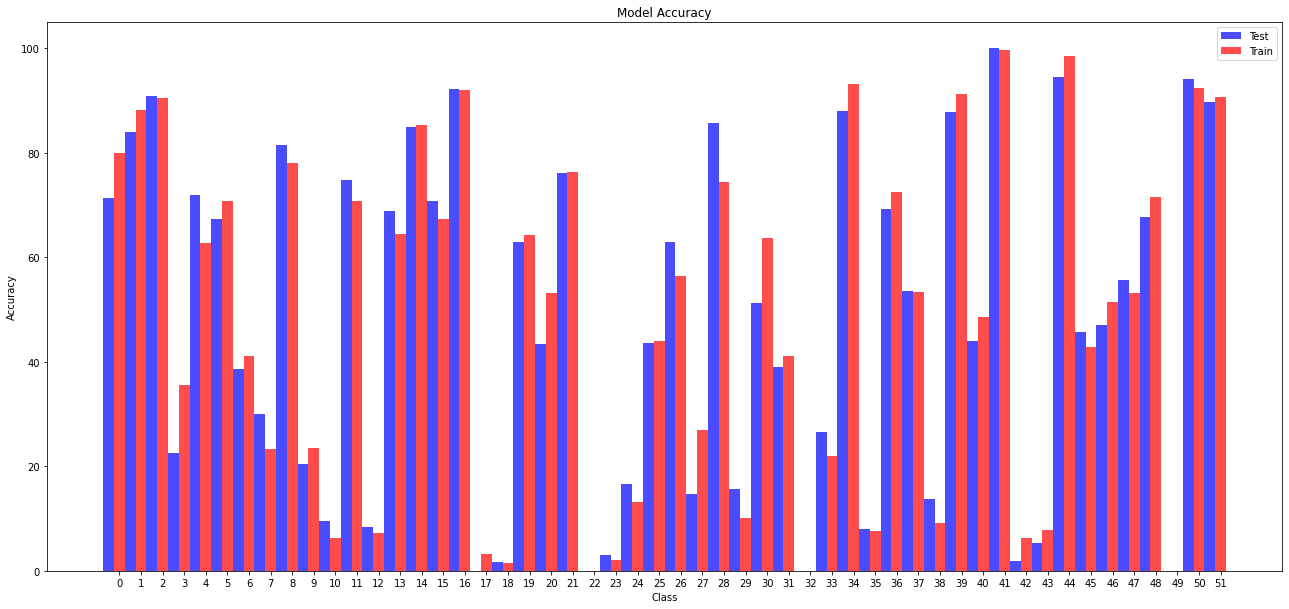

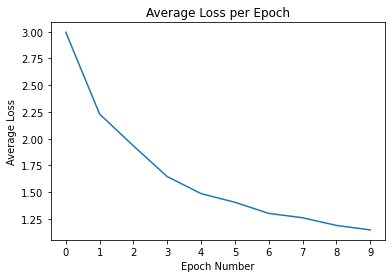

In [16]:
learning_rate = 0.07
batch_size = 128
train_loader4 = torch.utils.data.DataLoader(dataset2, batch_size = batch_size, sampler = train_sampler2, num_workers = 16)
test_loader4 = torch.utils.data.DataLoader(dataset2, batch_size = batch_size, sampler = test_sampler2, num_workers = 16)
model = Model(len(dataset2.classes))
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
print("Batch Size is 128 and learning rate is increased to 0.07")
losses = fit(model, train_loader4, device, criterion, optimizer, number_of_epochs)
print("Train Accuracy :", model_accuracy(model, train_loader4), "%")
print("Test Accuracy :", model_accuracy(model, test_loader4), "%")
classesAccuracy(model, test_loader4, train_loader4)
averageLossesPlot(losses)

Batch Size is 128 and learning rate is increased to 0.03
epoch 1, train_loss: 3.264, time elapsed: 33.062859 seconds
epoch 2, train_loss: 2.439, time elapsed: 33.283079 seconds
epoch 3, train_loss: 2.047, time elapsed: 34.834129 seconds
epoch 4, train_loss: 1.822, time elapsed: 35.419478 seconds
epoch 5, train_loss: 1.678, time elapsed: 35.851005 seconds
epoch 6, train_loss: 1.550, time elapsed: 34.808835 seconds
epoch 7, train_loss: 1.477, time elapsed: 35.091692 seconds
epoch 8, train_loss: 1.385, time elapsed: 35.132407 seconds
epoch 9, train_loss: 1.302, time elapsed: 34.329463 seconds
epoch 10, train_loss: 1.245, time elapsed: 32.902934 seconds
total training time: 5.745 minutes
Train Accuracy : 62.54026845637584 %
Test Accuracy : 60.39736877433212 %


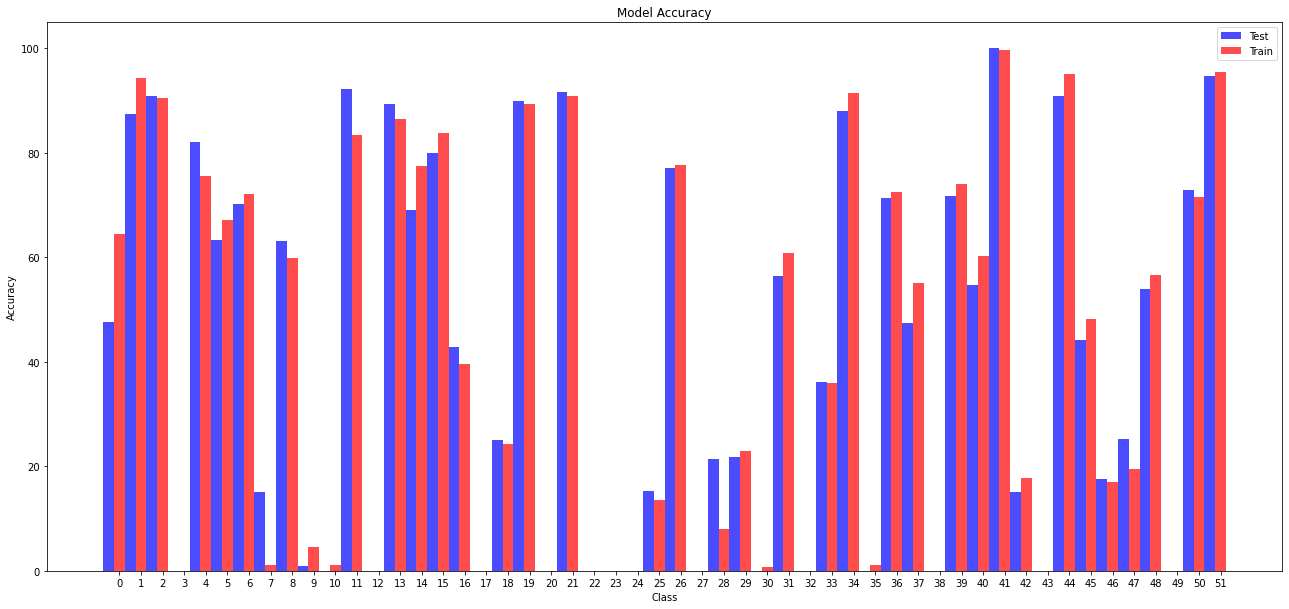

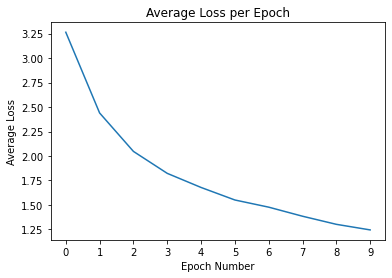

In [18]:
learning_rate = 0.03
batch_size = 128
train_loader4 = torch.utils.data.DataLoader(dataset2, batch_size = batch_size, sampler = train_sampler2, num_workers = 16)
test_loader4 = torch.utils.data.DataLoader(dataset2, batch_size = batch_size, sampler = test_sampler2, num_workers = 16)
model = Model(len(dataset2.classes))
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
print("Batch Size is 128 and learning rate is increased to 0.03")
losses = fit(model, train_loader4, device, criterion, optimizer, number_of_epochs)
print("Train Accuracy :", model_accuracy(model, train_loader4), "%")
print("Test Accuracy :", model_accuracy(model, test_loader4), "%")
classesAccuracy(model, test_loader4, train_loader4)
averageLossesPlot(losses)

It is clear that with batch size equal to 128, both increasing and decreasing learning rate will lower our performance and the best option is to not change it. Between these 2, increasing is better because theory suggests that when multiplying the batch size by k, one should multiply the learning rate by sqrt(k) to keep the variance in the gradient expectation constant.bHowever, recent experiments with large mini-batches suggest for a simpler linear scaling rule, i.e multiply your learning rate by k when using mini-batch size of kN.

## Part 8:
Momentum combined with stochastic gradient decent can help accelerating convergence by introducing an extra term γ when updating weights:

vt=γv(t−1)+η∇θJ(θ)

θ=θ−vt

The momentum term increases for dimensions whose gradients point in the same directions and reduces updates for dimensions whose gradients change directions. As a result we gain faster and smoother convergence. But if the momentum is not choosen wisely we might miss the local minima.

Momentum : 0.5
epoch 1, train_loss: 2.509, time elapsed: 39.008574 seconds
epoch 2, train_loss: 1.717, time elapsed: 39.508865 seconds
epoch 3, train_loss: 1.428, time elapsed: 39.085519 seconds
epoch 4, train_loss: 1.281, time elapsed: 38.975158 seconds
epoch 5, train_loss: 1.180, time elapsed: 38.921483 seconds
epoch 6, train_loss: 1.140, time elapsed: 38.588811 seconds
epoch 7, train_loss: 1.058, time elapsed: 39.479888 seconds
epoch 8, train_loss: 1.003, time elapsed: 39.899909 seconds
epoch 9, train_loss: 0.955, time elapsed: 40.930098 seconds
epoch 10, train_loss: 0.909, time elapsed: 41.033112 seconds
total training time: 6.591 minutes
Train Accuracy : 70.42281879194631 %
Test Accuracy : 69.06967378171566 %


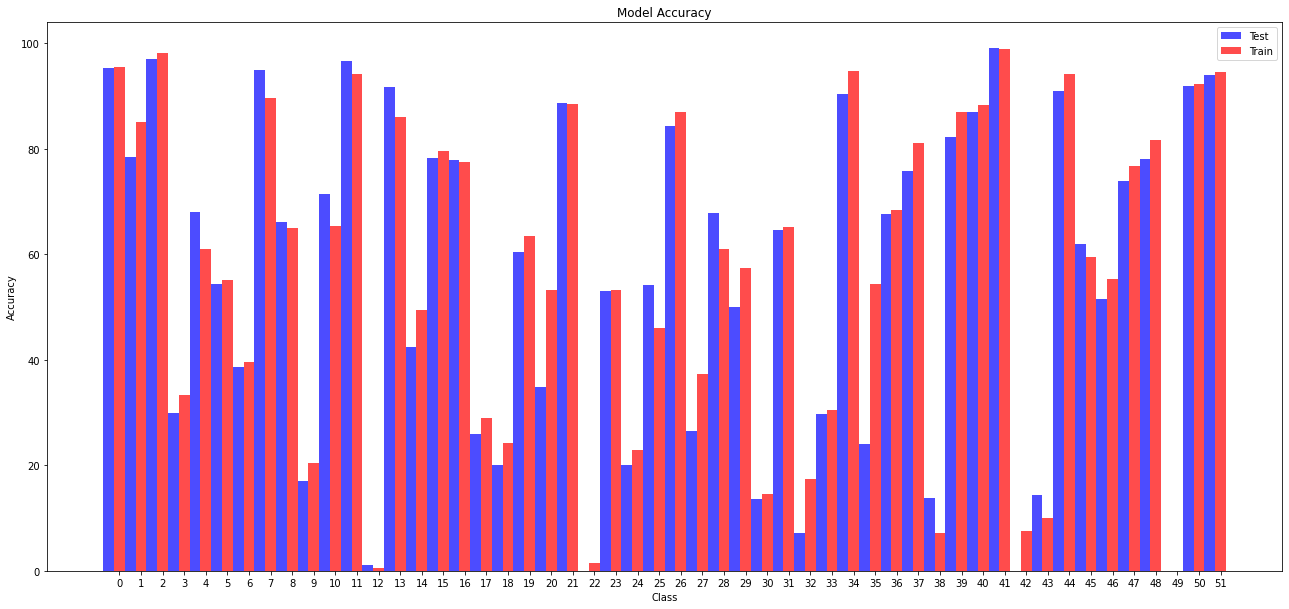

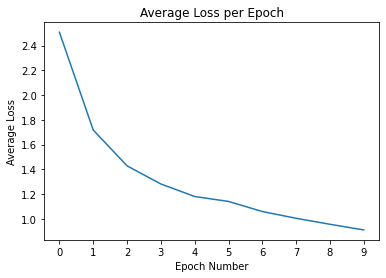

Momentum : 0.9
epoch 1, train_loss: 3.089, time elapsed: 41.730659 seconds
epoch 2, train_loss: 2.829, time elapsed: 40.94133 seconds
epoch 3, train_loss: 2.293, time elapsed: 40.626224 seconds
epoch 4, train_loss: 2.145, time elapsed: 40.580354 seconds
epoch 5, train_loss: 1.999, time elapsed: 40.870944 seconds
epoch 6, train_loss: 2.003, time elapsed: 40.777858 seconds
epoch 7, train_loss: 2.062, time elapsed: 40.9672 seconds
epoch 8, train_loss: 2.015, time elapsed: 41.714561 seconds
epoch 9, train_loss: 2.134, time elapsed: 40.790684 seconds
epoch 10, train_loss: 1.961, time elapsed: 42.493523 seconds
total training time: 6.858 minutes
Train Accuracy : 33.38255033557047 %
Test Accuracy : 31.735803463552156 %


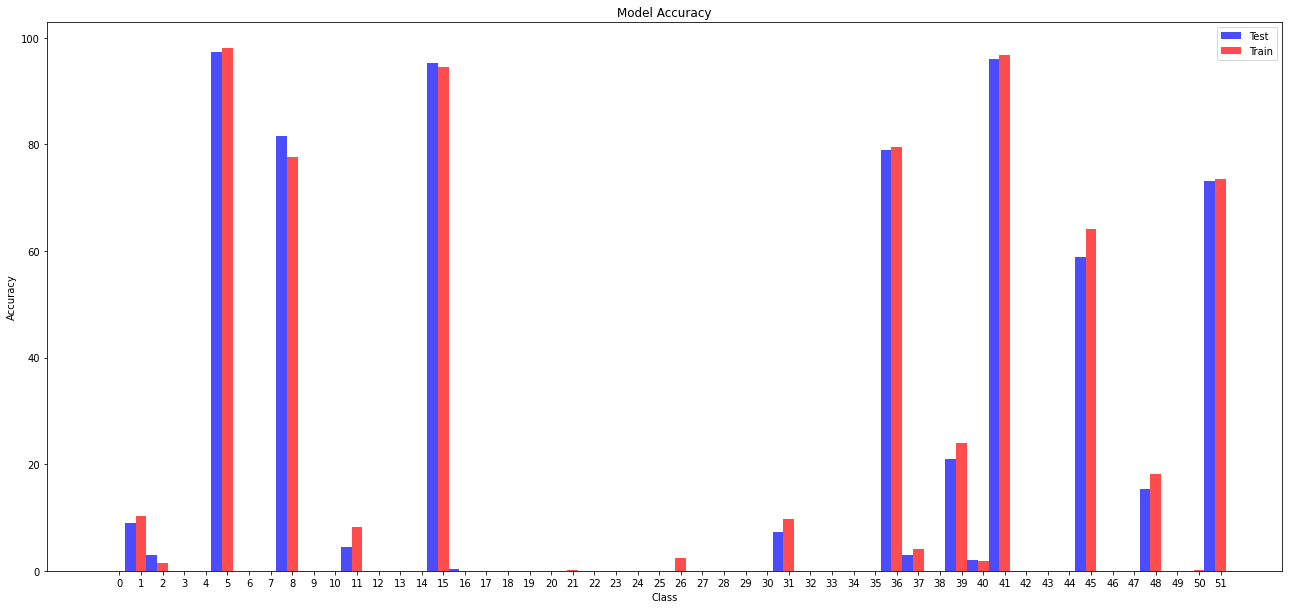

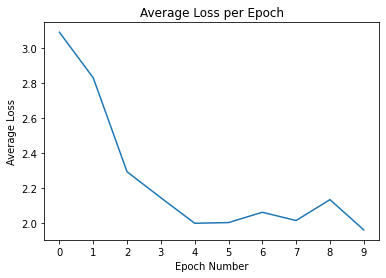

Momentum : 0.98
epoch 1, train_loss: nan, time elapsed: 40.623432 seconds
epoch 2, train_loss: nan, time elapsed: 40.679958 seconds
epoch 3, train_loss: nan, time elapsed: 41.289577 seconds
epoch 4, train_loss: nan, time elapsed: 42.146503 seconds
epoch 5, train_loss: nan, time elapsed: 40.935576 seconds
epoch 6, train_loss: nan, time elapsed: 42.62738 seconds
epoch 7, train_loss: nan, time elapsed: 42.59068 seconds
epoch 8, train_loss: nan, time elapsed: 41.543101 seconds
epoch 9, train_loss: nan, time elapsed: 40.457093 seconds
epoch 10, train_loss: nan, time elapsed: 41.942344 seconds
total training time: 6.914 minutes
Train Accuracy : 0.30201342281879195 %
Test Accuracy : 0.2819170358437374 %


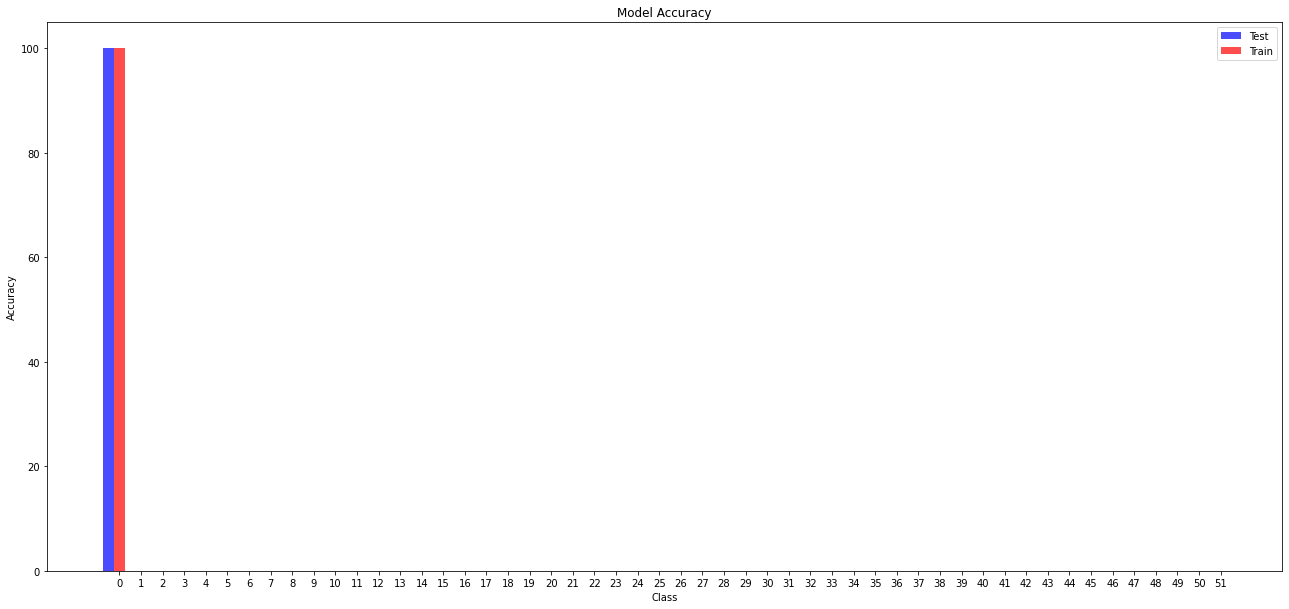

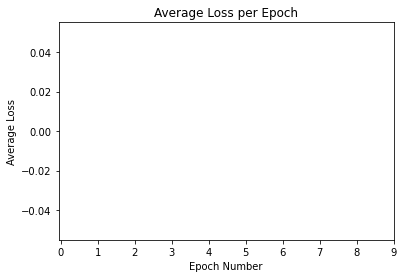

In [24]:
batch_size = 64
learning_rate = 0.05
mms= [0.5, 0.9, 0.98]
for mm in mms:
  model = Model(len(dataset2.classes))
  model = model.to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum = mm)
  print("Momentum :", mm)
  losses = fit(model, train_loader2, device, criterion, optimizer, number_of_epochs)
  print("Train Accuracy :", model_accuracy(model, train_loader2), "%")
  print("Test Accuracy :", model_accuracy(model, test_loader2), "%")
  classesAccuracy(model, test_loader2, train_loader2)
  averageLossesPlot(losses)

It could be seen that the best momentum value for our model is 0.5 with 70% accuracy. Momentum equal to 0.98 had failed to train the model because as I said before it might jump over the local minima and might never reach it. In conclusion increasing momentum value won't increase our accuracy and performance because it might swing back and forward around local minima. 

## Part 9:
Now we try higher epoch of 20 which increases our accuracy by far and gives us about 75% accuracy. Generally whenever you want to optimize you use gradient descent. In one iteration alone you can not guarantee that the gradient descent algorithm would converge to a local minima with the specified learning rate. That is the reason why you iterate again for the gradient descent to converge better. Also The number of epochs is not that significant but more important is the the validation and training error(loss). As long as it keeps dropping training should continue and if the validation error starts increasing that might be a indication of overfitting. You should set the number of epochs as high as possible and terminate training based on the error rates. In machine learning there is an approach called early stop which plots loss or error per each epoch so yo can find out from which point model is startig to overfit. In deep learning early stop is not that effective because loss per epoch's plot of it could be wavy bsince it is stochastic. To deal with this problem, another approaches are used for avoiding the problem. Adding noise to different parts of models, like drop out or somehow batch normalization with a moderated batch size, help these learning algorithms not to over-fit even after so many epochs.

Number of Epochs : 20
epoch 1, train_loss: 2.500, time elapsed: 38.974049 seconds
epoch 2, train_loss: 1.703, time elapsed: 41.075998 seconds
epoch 3, train_loss: 1.407, time elapsed: 42.479398 seconds
epoch 4, train_loss: 1.260, time elapsed: 40.59212 seconds
epoch 5, train_loss: 1.150, time elapsed: 41.734479 seconds
epoch 6, train_loss: 1.080, time elapsed: 40.343566 seconds
epoch 7, train_loss: 1.021, time elapsed: 41.446187 seconds
epoch 8, train_loss: 0.973, time elapsed: 39.916371 seconds
epoch 9, train_loss: 0.937, time elapsed: 39.537733 seconds
epoch 10, train_loss: 0.893, time elapsed: 40.936891 seconds
epoch 11, train_loss: 0.857, time elapsed: 40.708679 seconds
epoch 12, train_loss: 0.830, time elapsed: 40.907879 seconds
epoch 13, train_loss: 0.811, time elapsed: 40.607989 seconds
epoch 14, train_loss: 0.776, time elapsed: 40.594976 seconds
epoch 15, train_loss: 0.761, time elapsed: 40.186813 seconds
epoch 16, train_loss: 0.738, time elapsed: 39.996183 seconds
epoch 17, tr

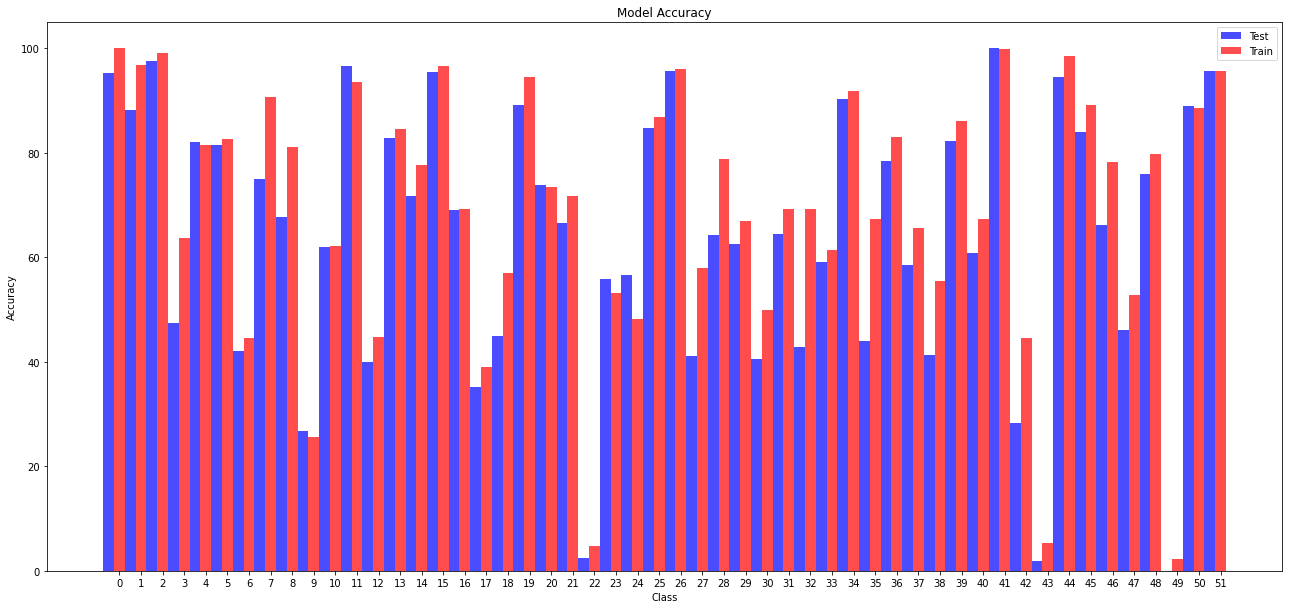

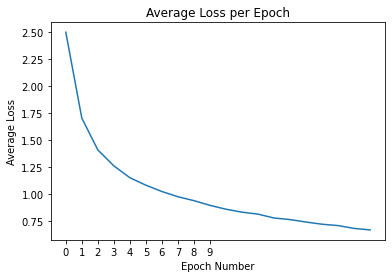

In [29]:
mm = 0.5
number_of_epochs = 20
activation_function = F.relu
model = Model(len(dataset2.classes))
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum = mm)
print("Number of Epochs :", 20)
losses = fit(model, train_loader2, device, criterion, optimizer, number_of_epochs)
print("Train Accuracy :", model_accuracy(model, train_loader2), "%")
print("Test Accuracy :", model_accuracy(model, test_loader2), "%")
classesAccuracy(model, test_loader2, train_loader2)
averageLossesPlot(losses)

## Part 10:
In this part we use tanh and leaky relu as activation functions. Tanh increases our performance a liitle bit but leaky relu decreases it. Here is a great link for more information on these activation functions:
https://towardsdatascience.com/complete-guide-of-activation-functions-34076e95d044

Activation Function : tanh


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


epoch 1, train_loss: 2.015, time elapsed: 42.974002 seconds
epoch 2, train_loss: 1.347, time elapsed: 41.517305 seconds
epoch 3, train_loss: 1.178, time elapsed: 39.900258 seconds
epoch 4, train_loss: 1.080, time elapsed: 39.915567 seconds
epoch 5, train_loss: 1.011, time elapsed: 40.212768 seconds
epoch 6, train_loss: 0.963, time elapsed: 40.038656 seconds
epoch 7, train_loss: 0.909, time elapsed: 38.956911 seconds
epoch 8, train_loss: 0.863, time elapsed: 39.105845 seconds
epoch 9, train_loss: 0.845, time elapsed: 39.04055 seconds
epoch 10, train_loss: 0.807, time elapsed: 39.153982 seconds
epoch 11, train_loss: 0.785, time elapsed: 39.426888 seconds
epoch 12, train_loss: 0.755, time elapsed: 39.254931 seconds
epoch 13, train_loss: 0.742, time elapsed: 39.189266 seconds
epoch 14, train_loss: 0.711, time elapsed: 38.893387 seconds
epoch 15, train_loss: 0.689, time elapsed: 38.743365 seconds
epoch 16, train_loss: 0.677, time elapsed: 39.064876 seconds
epoch 17, train_loss: 0.653, time 

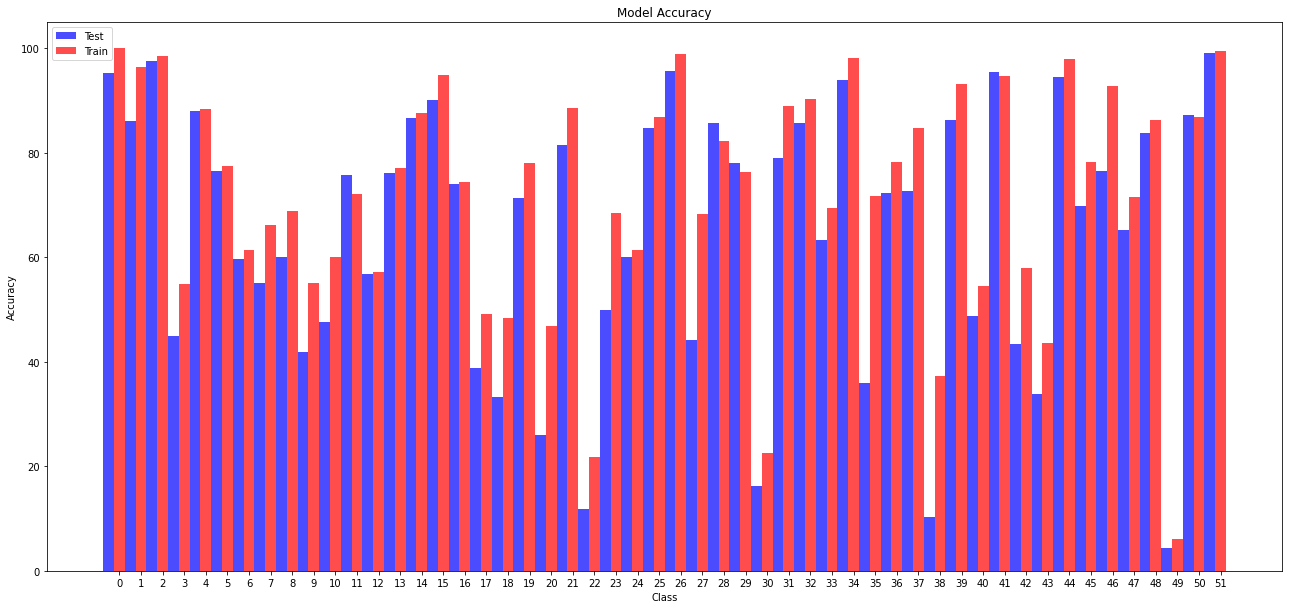

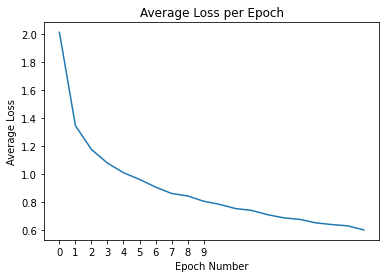

In [30]:
number_of_epochs = 20
activation_function = F.tanh
class Model(nn.Module):
    def __init__(self, class_num, act = activation_function):
        super(Model, self).__init__()

        self.layer1 = nn.Linear(1 * 80 * 60, 90 * 20 * 15)
        self.act1 = act

        self.layer2 = nn.Linear(90 * 20 * 15, 90 * 10 * 5)
        self.act2 = act

        self.layer3 = nn.Linear(90 * 10 * 5, 45 * 5 * 5)
        self.act3 = act

        self.layer4 = nn.Linear(45 * 5 * 5, 125)
        self.act4 = act

        self.layer5 = nn.Linear(125, class_num)

    def forward(self, x):

        x = x.view(x.size(0), -1)

        x = self.layer1(x)
        x = self.act1(x)

        x = self.layer2(x)
        x = self.act2(x)

        x = self.layer3(x)
        x = self.act3(x)

        x = self.layer4(x)
        x = self.act4(x)

        x = self.layer5(x)
        return x
model = Model(len(dataset2.classes))
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum = mm)
print("Activation Function :", "tanh")
losses = fit(model, train_loader2, device, criterion, optimizer, number_of_epochs)
print("Train Accuracy :", model_accuracy(model, train_loader2), "%")
print("Test Accuracy :", model_accuracy(model, test_loader2), "%")
classesAccuracy(model, test_loader2, train_loader2)
averageLossesPlot(losses)

Activation Function : Leaky Relu
epoch 1, train_loss: 2.488, time elapsed: 38.158405 seconds
epoch 2, train_loss: 1.692, time elapsed: 38.06769 seconds
epoch 3, train_loss: 1.454, time elapsed: 38.434574 seconds
epoch 4, train_loss: 1.304, time elapsed: 38.178851 seconds
epoch 5, train_loss: 1.199, time elapsed: 38.204131 seconds
epoch 6, train_loss: 1.097, time elapsed: 38.161417 seconds
epoch 7, train_loss: 1.069, time elapsed: 37.995517 seconds
epoch 8, train_loss: 1.007, time elapsed: 37.892846 seconds
epoch 9, train_loss: 0.947, time elapsed: 38.304428 seconds
epoch 10, train_loss: 0.912, time elapsed: 38.307841 seconds
epoch 11, train_loss: 0.877, time elapsed: 38.141538 seconds
epoch 12, train_loss: 0.847, time elapsed: 37.729175 seconds
epoch 13, train_loss: 0.822, time elapsed: 38.314161 seconds
epoch 14, train_loss: 0.786, time elapsed: 38.010205 seconds
epoch 15, train_loss: 0.769, time elapsed: 38.026496 seconds
epoch 16, train_loss: 0.742, time elapsed: 38.497692 seconds
e

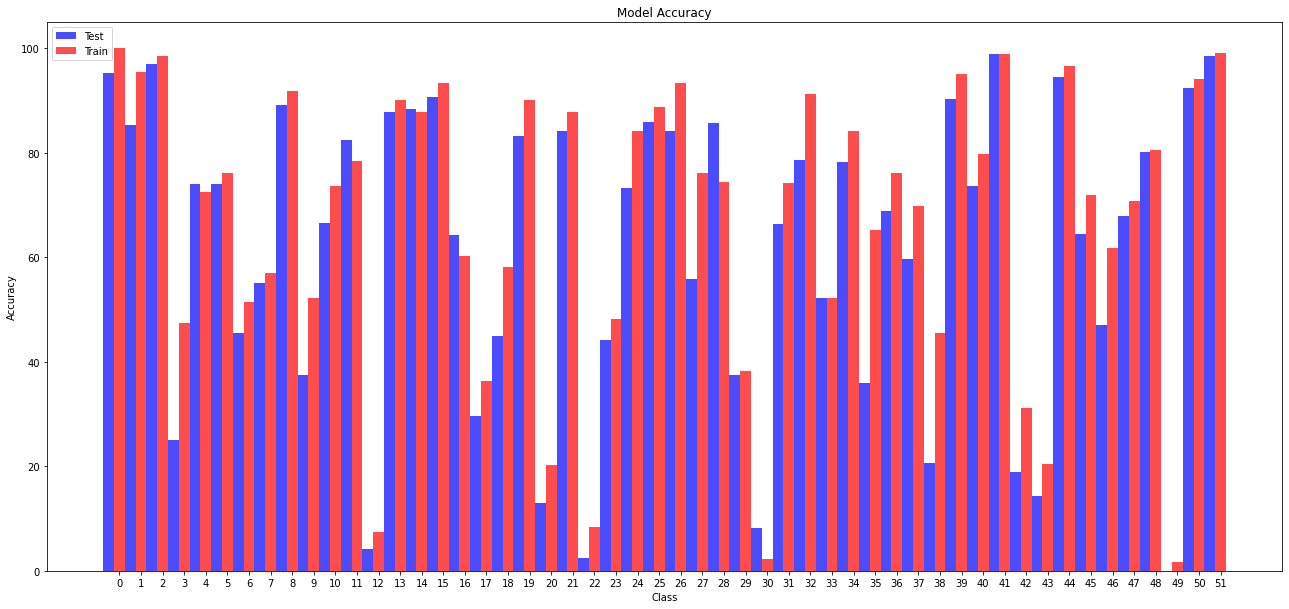

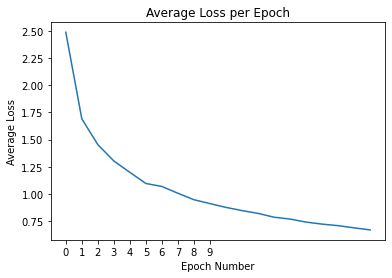

In [31]:
number_of_epochs = 20
activation_function = F.leaky_relu
class Model(nn.Module):
    def __init__(self, class_num, act = activation_function):
        super(Model, self).__init__()

        self.layer1 = nn.Linear(1 * 80 * 60, 90 * 20 * 15)
        self.act1 = act

        self.layer2 = nn.Linear(90 * 20 * 15, 90 * 10 * 5)
        self.act2 = act

        self.layer3 = nn.Linear(90 * 10 * 5, 45 * 5 * 5)
        self.act3 = act

        self.layer4 = nn.Linear(45 * 5 * 5, 125)
        self.act4 = act

        self.layer5 = nn.Linear(125, class_num)

    def forward(self, x):

        x = x.view(x.size(0), -1)

        x = self.layer1(x)
        x = self.act1(x)

        x = self.layer2(x)
        x = self.act2(x)

        x = self.layer3(x)
        x = self.act3(x)

        x = self.layer4(x)
        x = self.act4(x)

        x = self.layer5(x)
        return x
model = Model(len(dataset2.classes))
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum = mm)
print("Activation Function :", "Leaky Relu")
losses = fit(model, train_loader2, device, criterion, optimizer, number_of_epochs)
print("Train Accuracy :", model_accuracy(model, train_loader2), "%")
print("Test Accuracy :", model_accuracy(model, test_loader2), "%")
classesAccuracy(model, test_loader2, train_loader2)
averageLossesPlot(losses)

## Part 11:
Techniques that seek to reduce overfitting (reduce generalization error) by keeping network weights small are referred to as regularization methods. More specifically, regularization refers to a class of approaches that add additional information to transform an ill-posed problem into a more stable well-posed problem. The simplest and perhaps most common regularization method is to add a penalty to the loss function in proportion to the size of the weights in the model. Weight decay is the method which Penalizes the model during training based on the magnitude of the weights.
This will encourage the model to map the inputs to the outputs of the training dataset in such a way that the weights of the model are kept small. A simple alternative to gathering more data is to reduce the size of the model or improve regularization, by adjusting hyperparameters such as weight decay coefficients. 

In weight decay we add the squares of all the parameters to our loss function however it might result in our loss getting so huge that the best model would be to set all the parameters to 0. To prevent that from happening, we multiply the sum of squares with another smaller number. This number is called weight decay or wd.
Our loss function now looks as follows:

Loss = MSE(y_hat, y) + wd * sum(w^2)

When we update weights using gradient descent we do the following:

w(t) = w(t-1) - lr * dLoss / dw

That is from now on, we would not only subtract the learning rate * gradient from the weights but also 2 * wd * w . We are subtracting a constant times the weight from the original weight. This is why it is called weight decay.

Usage of weight decay in this model decreases performance. Accuracy od 0.1 is around 8% and 0.01 is about 27%.

epoch 1, train_loss: 3.447, time elapsed: 43.329921 seconds
epoch 2, train_loss: 3.382, time elapsed: 43.267422 seconds
epoch 3, train_loss: 3.376, time elapsed: 43.258122 seconds
epoch 4, train_loss: 3.378, time elapsed: 43.165877 seconds
epoch 5, train_loss: 3.373, time elapsed: 43.113063 seconds
epoch 6, train_loss: 3.376, time elapsed: 43.15288 seconds
epoch 7, train_loss: 3.374, time elapsed: 43.174165 seconds
epoch 8, train_loss: 3.380, time elapsed: 43.145669 seconds
epoch 9, train_loss: 3.379, time elapsed: 43.013089 seconds
epoch 10, train_loss: 3.382, time elapsed: 43.123755 seconds
epoch 11, train_loss: 3.373, time elapsed: 43.139612 seconds
epoch 12, train_loss: 3.381, time elapsed: 43.176882 seconds
epoch 13, train_loss: 3.374, time elapsed: 43.095668 seconds
epoch 14, train_loss: 3.373, time elapsed: 43.066043 seconds
epoch 15, train_loss: 3.374, time elapsed: 43.138107 seconds
epoch 16, train_loss: 3.378, time elapsed: 43.087568 seconds
epoch 17, train_loss: 3.382, time 

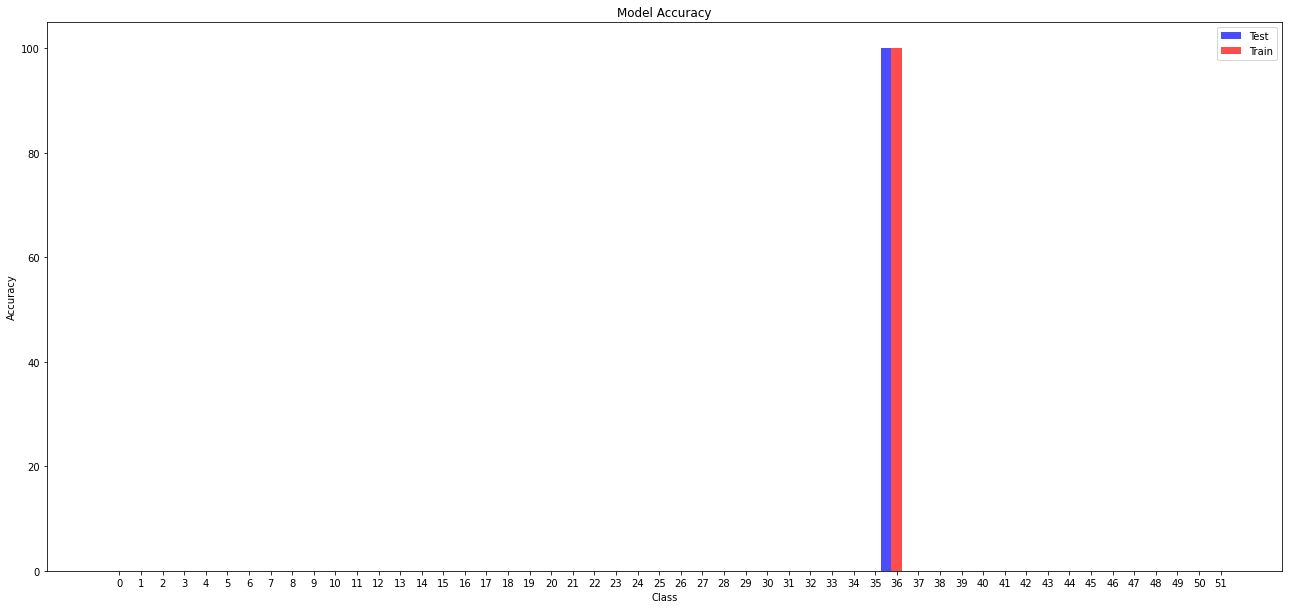

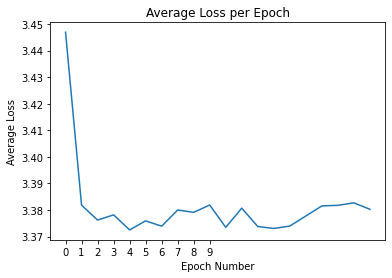

In [34]:
weightDecay = 0.1
activation_function = F.relu
model = Model(len(dataset2.classes))
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum = mm, weight_decay = weightDecay)
losses = fit(model, train_loader2, device, criterion, optimizer, number_of_epochs)
print("Train Accuracy :", model_accuracy(model, train_loader2), "%")
print("Test Accuracy :", model_accuracy(model, test_loader2), "%")
classesAccuracy(model, test_loader2, train_loader2)
averageLossesPlot(losses)

epoch 1, train_loss: 2.638, time elapsed: 43.008243 seconds
epoch 2, train_loss: 2.094, time elapsed: 43.159011 seconds
epoch 3, train_loss: 1.954, time elapsed: 43.065257 seconds
epoch 4, train_loss: 1.824, time elapsed: 43.115913 seconds
epoch 5, train_loss: 1.872, time elapsed: 43.171346 seconds
epoch 6, train_loss: 1.782, time elapsed: 43.238087 seconds
epoch 7, train_loss: 2.023, time elapsed: 43.173834 seconds
epoch 8, train_loss: 1.831, time elapsed: 43.059028 seconds
epoch 9, train_loss: 1.872, time elapsed: 43.07693 seconds
epoch 10, train_loss: 1.869, time elapsed: 43.025986 seconds
epoch 11, train_loss: 1.835, time elapsed: 43.074005 seconds
epoch 12, train_loss: 1.773, time elapsed: 43.345841 seconds
epoch 13, train_loss: 1.777, time elapsed: 43.126586 seconds
epoch 14, train_loss: 1.825, time elapsed: 43.20692 seconds
epoch 15, train_loss: 1.874, time elapsed: 43.055284 seconds
epoch 16, train_loss: 1.734, time elapsed: 43.192413 seconds
epoch 17, train_loss: 1.863, time e

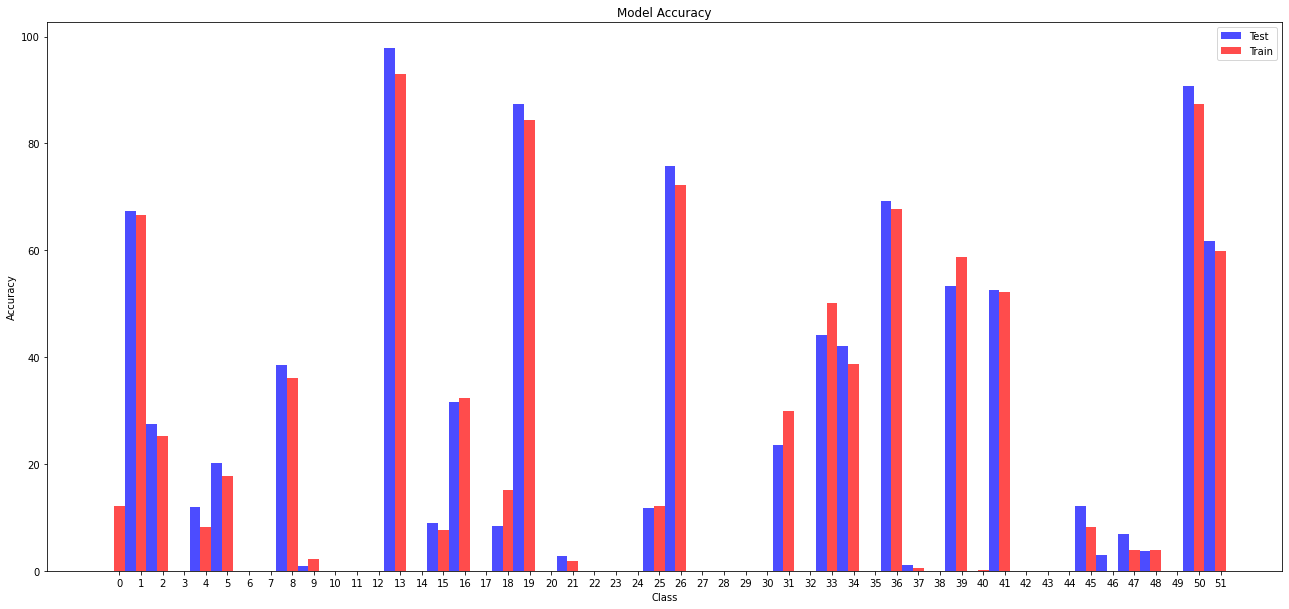

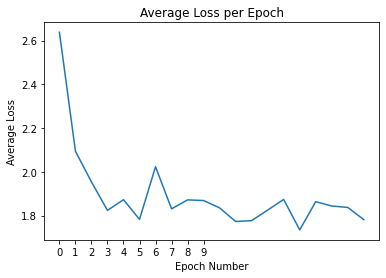

In [35]:
weightDecay = 0.01
model = Model(len(dataset2.classes))
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum = mm, weight_decay = weightDecay)
losses = fit(model, train_loader2, device, criterion, optimizer, number_of_epochs)
print("Train Accuracy :", model_accuracy(model, train_loader2), "%")
print("Test Accuracy :", model_accuracy(model, test_loader2), "%")
classesAccuracy(model, test_loader2, train_loader2)
averageLossesPlot(losses)